# Lexicon Score based on BoE Wordlist

### 1. Import the data

In [3]:
import pandas as pd
import re                                               # Regular expression operations on strings.
from collections import defaultdict                     # Creating dictionaries that return default value for nonexistent keys.
from nltk.corpus import wordnet as wn                   # Lexical database for retrieving word relationships & meanings.
from nltk.stem import WordNetLemmatizer, PorterStemmer  # Reducing words to base or root form.
import contractions                                     # Expanding/contracting text contractions.
from nltk.corpus import stopwords                       # Providing list of common words to exclude from analysis.
from nltk import word_tokenize, pos_tag                 # Splitting text into words and tags with part of speech
from nltk.stem import WordNetLemmatizer, PorterStemmer  # Reducing words to base or root form.

In [4]:
# Load the CSV file as speeches
#speeches = pd.read_csv('/Users/kaferrante/Documents/Python/_Course4_Project/all_speeches.csv')
speeches = pd.read_csv(r"/Users/rebo/Documents/LSE/Course 4 - EP/Initial datasets/all_speeches.csv")

# View the DataFrame
speeches.head()

reference    country        date                               title  \
0  r901128a_BOA  australia  1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia  1991-10-03                                       
2  r920314a_BOA  australia  1992-03-14                                       
3  r920529a_BOA  australia  1992-05-29                                       
4  r920817a_BOA  australia  1992-08-17                                       

   author  is_gov                                               text  
0  fraser       0  They would no doubt argue that to have two obj...  
1  fraser       0  Today I wish to talk about real interest rates...  
2  fraser       0  I welcome this opportunity to talk about prosp...  
3  fraser       0  It is a pleasure to have this opportunity to a...  
4  fraser       0  As a long-time fan of Don Sanders, I am deligh...

In [5]:
# Correcting for Edward George as Governor
def correct_is_gov_column(speeches: pd.DataFrame):
    """
    Correct the 'is_gov' value for Edward George between 1993 and 2003.

    Parameters:
    speeches_df (DataFrame): Central bank speeches.

    Returns:
    DataFrame: Updated speeches DataFrame with corrected 'is_gov' values.
    """
    # Make sure date is datetime first
    speeches['date'] = pd.to_datetime(speeches['date'], errors='coerce')
    
    # Apply correction
    condition = (
        (speeches['author'].str.lower() == 'george') &
        (speeches['date'].dt.year > 1993) &
        (speeches['date'].dt.year < 2004)
    )
    speeches.loc[condition, 'is_gov'] = 1  # 1 means Governor
    
    return speeches

# Correct the is_gov column
speeches = correct_is_gov_column(speeches)

# Quick check if it worked
display(speeches[speeches['author'].str.lower() == 'george'].head())

reference         country       date              title  author  \
4961  r980915a_BOE  united kingdom 1998-09-15             Speech  george   
4962  r981021b_BOE  united kingdom 1998-10-21  Britain in Europe  george   
4966  r981119a_BOE  united kingdom 1998-11-19             Speech  george   
4969  r990112a_BOE  united kingdom 1999-01-12             Speech  george   
4970  r990118a_BOE  united kingdom 1999-01-18             Speech  george   

      is_gov                                               text  
4961       1  Thank you, Chairman. I'm actually very pleased...  
4962       1  It's a great pleasure to be here in the beauti...  
4966       1  Let me put some of the recent newspaper headli...  
4969       1  I am only too well aware of the pressure curre...  
4970       1  It would be a masterly understatement to descr...

In [6]:
# Load the Excel file of BoE sentiment labelled wordlist
#sentiment_lexicon = pd.read_excel('/Users/kaferrante/Documents/Python/_Course4_Project/sentiment_labelled_wordlist.xlsx')
sentiment_lexicon = pd.read_excel(r"/Users/rebo/Documents/LSE/Course 4 - EP/Initial datasets/LSE_DA_BoE_Employer_project_Sentiment-labelled_wordlist-2.xlsx")

# View the DataFrame
sentiment_lexicon.head()

Word  Negative  Positive  Uncertainty  Litigious  Strong  Weak  \
0       ABANDON         1         0            0          0       0     0   
1     ABANDONED         1         0            0          0       0     0   
2    ABANDONING         1         0            0          0       0     0   
3   ABANDONMENT         1         0            0          0       0     0   
4  ABANDONMENTS         1         0            0          0       0     0   

   Constraining  
0             0  
1             0  
2             0  
3             0  
4             0

In [7]:
# Rename columns
sentiment_lexicon = sentiment_lexicon.rename(columns={
    'Negative': 'negative',
    'Positive': 'positive',
    'Uncertainty': 'uncertainty',
    'Litigious': 'litigious',
    'Strong': 'strong',
    'Weak': 'weak',
    'Constraining': 'constraining',
})

# View the DataFrame
sentiment_lexicon.head()

Word  negative  positive  uncertainty  litigious  strong  weak  \
0       ABANDON         1         0            0          0       0     0   
1     ABANDONED         1         0            0          0       0     0   
2    ABANDONING         1         0            0          0       0     0   
3   ABANDONMENT         1         0            0          0       0     0   
4  ABANDONMENTS         1         0            0          0       0     0   

   constraining  
0             0  
1             0  
2             0  
3             0  
4             0

In [8]:
speeches.dtypes
speeches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7721 entries, 0 to 7720
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   reference  7721 non-null   object        
 1   country    7721 non-null   object        
 2   date       7721 non-null   datetime64[ns]
 3   title      7721 non-null   object        
 4   author     7721 non-null   object        
 5   is_gov     7721 non-null   int64         
 6   text       7721 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 422.4+ KB


In [9]:
# Check the number of unique values.
speeches.nunique()

reference    7721
country         8
date         4410
title        6218
author        325
is_gov          2
text         7692
dtype: int64

In [10]:
# Create a normalized version of the 'text' column
speeches['text_norm'] = speeches['text'].str.strip().str.lower()

# Find duplicate 'text_norm' entries
duplicate_mask = speeches['text_norm'].duplicated(keep=False)

# Extract all duplicates based on normalized text
duplicates = speeches[duplicate_mask]

In [11]:
# Show the entire row for text duplicates
duplicates

reference         country       date  \
564    r101026a_BOC          canada 2010-10-26   
565    r101027a_BOC          canada 2010-10-27   
610    r120424a_BOC          canada 2012-04-24   
611    r120425a_BOC          canada 2012-04-25   
624    r121030a_BOC          canada 2012-10-30   
625    r121031a_BOC          canada 2012-10-31   
668    r140429a_BOC          canada 2014-04-29   
669    r140430a_BOC          canada 2014-04-30   
1182   r020121a_ECB       euro area 2002-01-21   
1186   r020221a_ECB       euro area 2002-02-21   
2824   r180507a_ECB       euro area 2018-05-07   
2829   r180514c_ECB       euro area 2018-05-14   
3266   r981210a_BOJ           japan 1998-12-10   
3267   r981211a_BOJ           japan 1998-12-11   
3422   r071101a_BOJ           japan 2007-11-01   
3423   r071102a_BOJ           japan 2007-11-02   
3506   r100413a_BOJ           japan 2010-04-13   
3507   r100420a_BOJ           japan 2010-04-20   
3744   r150610a_BOJ           japan 2015-06-10   
3746   r150616a_BOJ           japan 2015-06-16   
3803   r161102a_BOJ           japan 2016-11-02   
3808   r161122a_BOJ           japan 2016-11-22   
3886   r181206a_BOJ           japan 2018-12-06   
3887   r181207a_BOJ           japan 2018-12-07   
3922   r191119a_BOJ           japan 2019-11-19   
3926   r191129a_BOJ           japan 2019-11-29   
5203   r061024a_BOE  united kingdom 2006-10-24   
5658   r150226a_BOE  united kingdom 2015-02-26   
5952   r190517a_BOE  united kingdom 2019-05-17   
6035   r200903a_BOE  united kingdom 2020-09-03   
6038   r200909a_BOE  united kingdom 2020-09-09   
6081   r210421a_BOE  united kingdom 2021-04-21   
6082   r210429b_BOE  united kingdom 2021-04-29   
6095   r210601a_BOE  united kingdom 2021-06-01   
6099   r210617a_BOE  united kingdom 2021-06-17   
6115   r211020a_BOE  united kingdom 2021-10-20   
6116   r211103a_BOE  united kingdom 2021-11-03   
6120   r211203a_BOE  united kingdom 2021-12-03   
6135   r220428a_BOE  united kingdom 2022-04-28   
6142   r220526a_BOE  united kingdom 2022-05-26   
6598  r040103a_FOMC   united states 2004-01-03   
6603  r040114a_FOMC   united states 2004-01-14   
6611  r040225b_FOMC   united states 2004-02-25   
6612  r040226a_FOMC   united states 2004-02-26   
6626  r040331a_FOMC   united states 2004-03-31   
6645  r040514a_FOMC   united states 2004-05-14   
6658  r040621a_FOMC   united states 2004-06-21   
6697  r050112a_FOMC   united states 2005-01-12   
6699  r050119a_FOMC   united states 2005-01-19   
6700  r050127a_FOMC   united states 2005-01-27   
6705  r050224a_FOMC   united states 2005-02-24   
6758  r051012b_FOMC   united states 2005-10-12   
6761  r051013a_FOMC   united states 2005-10-13   
6824  r060615a_FOMC   united states 2006-06-15   
6826  r060616b_FOMC   united states 2006-06-16   
6875  r070426a_FOMC   united states 2007-04-26   
6891  r070623a_FOMC   united states 2007-06-23   

                                                  title     author  is_gov  \
564   Opening Statement before the House of Commons ...     carney       1   
565   Opening Statement before the Standing Senate C...     carney       1   
610   Opening Statement before the House of Commons ...     carney       1   
611   Opening Statement before the Senate Standing C...     carney       1   
624   Opening Statement before the House of Commons ...     carney       1   
625   Opening Statement before the Standing Senate C...     carney       1   
668   Opening Statement before the House of Commons ...      poloz       1   
669   Opening Statement before the Senate Standing C...      poloz       1   
1182          Securities and banking: bridges and walls    no_info       0   
1186          Securities and banking: bridges and walls   schioppa       0   
2824             Economic developments in the euro area      praet       0   
2829             Economic developments in the euro area      praet       0   
3266  Statement by Masaru Hayami, Governor of the Ba...     hayami       0   
3267  Statement b

## Since the number of duplicates is low and we can't securely validate the original version, I decided to remove them from the dataset.

In [13]:
# Keep only non-duplicates
speeches = speeches[~duplicate_mask]

### 2. Clean the data

**Text cleaned** by
- Removing unwanted characters
- Removing any special characters and punctuation
- Converting text to lower case
- Removing stopwords
- tokenisation: Split the cleaned text into individual words, so that text can be analysed at word level.
- Lemmatisation: Reduce words to its base or dictionary form (the lemma).

**Text cleaning functions**

In [17]:
# Preprocessing function
def preprocess_text(text):
    text = contractions.fix(text)  # Expand contractions i.e I'm not good goes to I am not good
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub('#', '', text)         # Remove hashtags
    text = re.sub(r'\W', ' ', text)      # Remove special characters
    text = text.lower()                  # Convert to lowercase
    #Below is to create a set of stop words from the NLTK library's predefined list but not is excluded.
    stop_words = set(stopwords.words('english')) - {'not'} 
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [18]:
# Define the tag map for POS tagging.
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

# Lemmatise the tokens with correct POS tags.
lemma_function = WordNetLemmatizer()

# Lemmatisation function.
def lemmatize_tokens(tokens):
    #For each word in the token list, it lemmatizes the word with the correct part-of-speech
    lemmatized_tokens = [lemma_function.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(tokens)]
    return lemmatized_tokens

**Apply text cleaning functions**

In [20]:
# Apply the preprocessing function
speeches['text_cleaned'] = speeches['text'].apply(preprocess_text)

In [21]:
# Apply the tokenisation function
speeches['text_tokenised'] = speeches['text_cleaned'].apply(word_tokenize)

In [22]:
# Apply the lemmatisation function
speeches['text_lemmatised'] = speeches['text_tokenised'].apply(lemmatize_tokens)

In [23]:
# Convert list of words into a string
speeches['text_lemmatised_str'] = speeches['text_lemmatised'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

In [24]:
# Count the number of words in original text
speeches['word_count_text'] = speeches['text'].str.split().apply(len)

In [25]:
# Count the number of words in lemmatised text
speeches['word_count_text_cleaned'] = speeches['text_lemmatised_str'].str.split().apply(len)

In [26]:
# View the Dataframe
speeches.head()

reference    country       date                               title  \
0  r901128a_BOA  australia 1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia 1991-10-03                                       
2  r920314a_BOA  australia 1992-03-14                                       
3  r920529a_BOA  australia 1992-05-29                                       
4  r920817a_BOA  australia 1992-08-17                                       

   author  is_gov                                               text  \
0  fraser       0  They would no doubt argue that to have two obj...   
1  fraser       0  Today I wish to talk about real interest rates...   
2  fraser       0  I welcome this opportunity to talk about prosp...   
3  fraser       0  It is a pleasure to have this opportunity to a...   
4  fraser       0  As a long-time fan of Don Sanders, I am deligh...   

                                           text_norm  \
0  they would no doubt argue that to have two obj...   
1  today i wish to talk about real interest rates...   
2  i welcome this opportunity to talk about prosp...   
3  it is a pleasure to have this opportunity to a...   
4  as a long-time fan of don sanders, i am deligh...   

                                        text_cleaned  \
0  would doubt argue two objectives like trying c...   
1  today wish talk real interest rates mainly his...   
2  welcome opportunity talk prospects banks austr...   
3  pleasure opportunity address influential gathe...   
4  long time fan sanders delighted participating ...   

                                      text_tokenised  \
0  [would, doubt, argue, two, objectives, like, t...   
1  [today, wish, talk, real, interest, rates, mai...   
2  [welcome, opportunity, talk, prospects, banks,...   
3  [pleasure, opportunity, address, influential, ...   
4  [long, time, fan, sanders, delighted, particip...   

                                     text_lemmatised  \
0  [would, doubt, argue, two, objective, like, tr...   
1  [today, wish, talk, real, interest, rate, main...   
2  [welcome, opportunity, talk, prospect, bank, a...   
3  [pleasure, opportunity, address, influential, ...   
4  [long, time, fan, sander, delight, participate...   

                                 text_lemmatised_str  word_count_text  \
0  would doubt argue two objective like try cake ...             3627   
1  today wish talk real interest rate mainly hist...             3054   
2  welcome opportunity talk prospect bank austral...             3399   
3  pleasure opportunity address influential gathe...             3841   
4  long time fan sander delight participate tribu...             4152   

   word_count_text_cleaned  
0                     1919  
1                     1754  
2                     1867  
3                     2123  
4                     2150

### 3. Calculating simple sentiment score with BoE Wordlist

**Sentiment score** is calculated as follows:
- positive and negative words in each speech are counted
- sentiment score = psotive word count - negative word count /  wordcount

In [29]:
# Prepare the lexicon
sentiment_lexicon = sentiment_lexicon.copy()

# Define categories
categories = [
     'negative',
     'positive',
     'uncertainty',
     'litigious',
     'strong',
     'weak',
     'constraining',
 ]

# Create dictionary of categories, containing words that belong to that category based on your sentiment lexicon.
word_sets = {
    cat: set(sentiment_lexicon.loc[sentiment_lexicon[cat] == 1, 'Word'].str.lower())
    for cat in categories
}

In [30]:
# Define function to apply the lexicon to the tokens
def lexicon_counts(tokens):
    return pd.Series({
        cat: sum(t in word_sets[cat] for t in tokens)
        for cat in categories
    })

# Apply the lexicon_counts function to 'text_lemmatised' column
category_counts = speeches['text_lemmatised'].apply(lexicon_counts)

# Concatenate category counts to the original DataFrame
speeches = pd.concat([speeches, category_counts], axis=1)

# Calculate total sentiment words across all categories for each speech
speeches['word_count_sentiment'] = category_counts.sum(axis=1)

# View the DataFrame
speeches.head()

reference    country       date                               title  \
0  r901128a_BOA  australia 1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia 1991-10-03                                       
2  r920314a_BOA  australia 1992-03-14                                       
3  r920529a_BOA  australia 1992-05-29                                       
4  r920817a_BOA  australia 1992-08-17                                       

   author  is_gov                                               text  \
0  fraser       0  They would no doubt argue that to have two obj...   
1  fraser       0  Today I wish to talk about real interest rates...   
2  fraser       0  I welcome this opportunity to talk about prosp...   
3  fraser       0  It is a pleasure to have this opportunity to a...   
4  fraser       0  As a long-time fan of Don Sanders, I am deligh...   

                                           text_norm  \
0  they would no doubt argue that to have two obj...   
1  today i wish to talk about real interest rates...   
2  i welcome this opportunity to talk about prosp...   
3  it is a pleasure to have this opportunity to a...   
4  as a long-time fan of don sanders, i am deligh...   

                                        text_cleaned  \
0  would doubt argue two objectives like trying c...   
1  today wish talk real interest rates mainly his...   
2  welcome opportunity talk prospects banks austr...   
3  pleasure opportunity address influential gathe...   
4  long time fan sanders delighted participating ...   

                                      text_tokenised  ... word_count_text  \
0  [would, doubt, argue, two, objectives, like, t...  ...            3627   
1  [today, wish, talk, real, interest, rates, mai...  ...            3054   
2  [welcome, opportunity, talk, prospects, banks,...  ...            3399   
3  [pleasure, opportunity, address, influential, ...  ...            3841   
4  [long, time, fan, sanders, delighted, particip...  ...            4152   

  word_count_text_cleaned  negative  positive  uncertainty  litigious  strong  \
0                    1919        84        58           32          5      10   
1                    1754        53        28           35          2       3   
2                    1867        43        67           33          8      11   
3                    2123        62        56           43          6       7   
4                    2150        72        62           42          6      12   

   weak  constraining  word_count_sentiment  
0    15            13                   217  
1    16            12                   149  
2    16            13                   191  
3    20             8                   202  
4    27            13                   234  

[5 rows x 22 columns]

In [31]:
# Calculate the sentiment score by subtracting the negative score from the positive score
# abd dividing by the total number of words in the lemmatised text
speeches['sentiment_lexicon_simple'] = (speeches['positive'] - speeches['negative'])/ speeches['word_count_sentiment']

In [32]:
# View the dataframe
speeches.head()

reference    country       date                               title  \
0  r901128a_BOA  australia 1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia 1991-10-03                                       
2  r920314a_BOA  australia 1992-03-14                                       
3  r920529a_BOA  australia 1992-05-29                                       
4  r920817a_BOA  australia 1992-08-17                                       

   author  is_gov                                               text  \
0  fraser       0  They would no doubt argue that to have two obj...   
1  fraser       0  Today I wish to talk about real interest rates...   
2  fraser       0  I welcome this opportunity to talk about prosp...   
3  fraser       0  It is a pleasure to have this opportunity to a...   
4  fraser       0  As a long-time fan of Don Sanders, I am deligh...   

                                           text_norm  \
0  they would no doubt argue that to have two obj...   
1  today i wish to talk about real interest rates...   
2  i welcome this opportunity to talk about prosp...   
3  it is a pleasure to have this opportunity to a...   
4  as a long-time fan of don sanders, i am deligh...   

                                        text_cleaned  \
0  would doubt argue two objectives like trying c...   
1  today wish talk real interest rates mainly his...   
2  welcome opportunity talk prospects banks austr...   
3  pleasure opportunity address influential gathe...   
4  long time fan sanders delighted participating ...   

                                      text_tokenised  ...  \
0  [would, doubt, argue, two, objectives, like, t...  ...   
1  [today, wish, talk, real, interest, rates, mai...  ...   
2  [welcome, opportunity, talk, prospects, banks,...  ...   
3  [pleasure, opportunity, address, influential, ...  ...   
4  [long, time, fan, sanders, delighted, particip...  ...   

  word_count_text_cleaned negative  positive  uncertainty  litigious  strong  \
0                    1919       84        58           32          5      10   
1                    1754       53        28           35          2       3   
2                    1867       43        67           33          8      11   
3                    2123       62        56           43          6       7   
4                    2150       72        62           42          6      12   

   weak  constraining  word_count_sentiment  sentiment_lexicon_simple  
0    15            13                   217                 -0.119816  
1    16            12                   149                 -0.167785  
2    16            13                   191                  0.125654  
3    20             8                   202                 -0.029703  
4    27            13                   234                 -0.042735  

[5 rows x 23 columns]

### 4. Calculate weighted sentiment score with BoE Wordlist

**Sentiment score** is calculated as follows:
- words in all categories in each speech are counted (positive, negative, uncertainty, litigious, strong, weak, constraining)
- weights are applied to each category to show how important the influence on the sentiment is
- sentiment score = category counts * category weights / wordcount

**Category weights** based on importance:
- Negative -1       Standard negative words
- Positive +1.5     Standard positive words - compensate for negatively skewed wordlist
- Uncertainty 0.2   Words expressing doubt or ambiguity, less impactful than outright negative or positive words
- Litigious -0.2    Words related to lawsuits or legal issues, potentially negative or impactful depending on context
- Strong +1.5       Words with high intensity or impact, thus given more weight
- Weak +0.5         Words with less impact, so given lesser weight than 'Strong' words
- Constraining -0.5 Words implying restriction or limitations, generally negative

In [37]:
# Assign weights to the categories
category_weights = {
    'negative': -1,
    'positive': 1.5,
    'uncertainty': 0.2,
    'litigious': -0.2,
    'strong': 1.5,
    'weak': 0.5,
    'constraining': -0.5
}

In [38]:
# Define function to apply the lexicon to the text
def lexicon_score_weighted(tokens):
    score = 0
    for cat in categories:
        count = sum(t in word_sets[cat] for t in tokens)
        score += count * category_weights[cat]
    return score

# Compute counts and store as a new column
speeches['sentiment_lexicon_weighted'] = speeches['text_lemmatised'].apply(lexicon_score_weighted) \
                                                    / speeches['word_count_sentiment']

# View the DataFrame
speeches.head()

reference    country       date                               title  \
0  r901128a_BOA  australia 1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia 1991-10-03                                       
2  r920314a_BOA  australia 1992-03-14                                       
3  r920529a_BOA  australia 1992-05-29                                       
4  r920817a_BOA  australia 1992-08-17                                       

   author  is_gov                                               text  \
0  fraser       0  They would no doubt argue that to have two obj...   
1  fraser       0  Today I wish to talk about real interest rates...   
2  fraser       0  I welcome this opportunity to talk about prosp...   
3  fraser       0  It is a pleasure to have this opportunity to a...   
4  fraser       0  As a long-time fan of Don Sanders, I am deligh...   

                                           text_norm  \
0  they would no doubt argue that to have two obj...   
1  today i wish to talk about real interest rates...   
2  i welcome this opportunity to talk about prosp...   
3  it is a pleasure to have this opportunity to a...   
4  as a long-time fan of don sanders, i am deligh...   

                                        text_cleaned  \
0  would doubt argue two objectives like trying c...   
1  today wish talk real interest rates mainly his...   
2  welcome opportunity talk prospects banks austr...   
3  pleasure opportunity address influential gathe...   
4  long time fan sanders delighted participating ...   

                                      text_tokenised  ... negative positive  \
0  [would, doubt, argue, two, objectives, like, t...  ...       84       58   
1  [today, wish, talk, real, interest, rates, mai...  ...       53       28   
2  [welcome, opportunity, talk, prospects, banks,...  ...       43       67   
3  [pleasure, opportunity, address, influential, ...  ...       62       56   
4  [long, time, fan, sanders, delighted, particip...  ...       72       62   

   uncertainty  litigious  strong  weak  constraining  word_count_sentiment  \
0           32          5      10    15            13                   217   
1           35          2       3    16            12                   149   
2           33          8      11    16            13                   191   
3           43          6       7    20             8                   202   
4           42          6      12    27            13                   234   

   sentiment_lexicon_simple  sentiment_lexicon_weighted  
0                 -0.119816                    0.112442  
1                 -0.167785                    0.014094  
2                  0.125654                    0.421466  
3                 -0.029703                    0.227228  
4                 -0.042735                    0.227350  

[5 rows x 24 columns]

### 5. Export the DataFrame

In [40]:
# Export the DataFrame to CSV
#speeches.to_csv('/Users/kaferrante/Documents/Python/_Course4_Project/speeches_sentiment.csv', index=False)
speeches.to_csv(r"/Users/rebo/Documents/LSE/Course 4 - EP/SENTIMENT/speeches_sentiment.csv")

In [41]:
# Load the CSV file as speeches
#speeches_test = pd.read_csv('/Users/kaferrante/Documents/Python/_Course4_Project/speeches_sentiment.csv')
speeches_sentiment = pd.read_csv(r"/Users/rebo/Documents/LSE/Course 4 - EP/SENTIMENT/speeches_sentiment.csv", index_col=0)

# View the DataFrame
speeches_sentiment.head()

reference    country        date                               title  \
0  r901128a_BOA  australia  1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia  1991-10-03                                       
2  r920314a_BOA  australia  1992-03-14                                       
3  r920529a_BOA  australia  1992-05-29                                       
4  r920817a_BOA  australia  1992-08-17                                       

   author  is_gov                                               text  \
0  fraser       0  They would no doubt argue that to have two obj...   
1  fraser       0  Today I wish to talk about real interest rates...   
2  fraser       0  I welcome this opportunity to talk about prosp...   
3  fraser       0  It is a pleasure to have this opportunity to a...   
4  fraser       0  As a long-time fan of Don Sanders, I am deligh...   

                                           text_norm  \
0  they would no doubt argue that to have two obj...   
1  today i wish to talk about real interest rates...   
2  i welcome this opportunity to talk about prosp...   
3  it is a pleasure to have this opportunity to a...   
4  as a long-time fan of don sanders, i am deligh...   

                                        text_cleaned  \
0  would doubt argue two objectives like trying c...   
1  today wish talk real interest rates mainly his...   
2  welcome opportunity talk prospects banks austr...   
3  pleasure opportunity address influential gathe...   
4  long time fan sanders delighted participating ...   

                                      text_tokenised  ... negative positive  \
0  ['would', 'doubt', 'argue', 'two', 'objectives...  ...       84       58   
1  ['today', 'wish', 'talk', 'real', 'interest', ...  ...       53       28   
2  ['welcome', 'opportunity', 'talk', 'prospects'...  ...       43       67   
3  ['pleasure', 'opportunity', 'address', 'influe...  ...       62       56   
4  ['long', 'time', 'fan', 'sanders', 'delighted'...  ...       72       62   

   uncertainty  litigious  strong  weak  constraining  word_count_sentiment  \
0           32          5      10    15            13                   217   
1           35          2       3    16            12                   149   
2           33          8      11    16            13                   191   
3           43          6       7    20             8                   202   
4           42          6      12    27            13                   234   

   sentiment_lexicon_simple  sentiment_lexicon_weighted  
0                 -0.119816                    0.112442  
1                 -0.167785                    0.014094  
2                  0.125654                    0.421466  
3                 -0.029703                    0.227228  
4                 -0.042735                    0.227350  

[5 rows x 24 columns]

In [42]:
speeches_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7664 entries, 0 to 7720
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   reference                   7664 non-null   object 
 1   country                     7664 non-null   object 
 2   date                        7664 non-null   object 
 3   title                       7664 non-null   object 
 4   author                      7664 non-null   object 
 5   is_gov                      7664 non-null   int64  
 6   text                        7664 non-null   object 
 7   text_norm                   7664 non-null   object 
 8   text_cleaned                7664 non-null   object 
 9   text_tokenised              7664 non-null   object 
 10  text_lemmatised             7664 non-null   object 
 11  text_lemmatised_str         7664 non-null   object 
 12  word_count_text             7664 non-null   int64  
 13  word_count_text_cleaned     7664 non-n

In [43]:
# There is one row where the sentiment scores are zero -> the text did not contain any sentiment words
zero_mask = (
    speeches_sentiment['sentiment_lexicon_simple'].isna() |
    speeches_sentiment['sentiment_lexicon_weighted'].isna()
)

zero_sentiment_speeches = speeches_sentiment[zero_mask]

# Display them
display(zero_sentiment_speeches)

reference country        date  \
795  r181025a_BOC  canada  2018-10-25   

                                                 title   author  is_gov  \
795  Money for Nothing? A Central Banker’s Take on ...  wilkins       0   

                                                  text  \
795  I - a FI - b FI - n bankofcanada.ca bankofcana...   

                                             text_norm  \
795  i - a fi - b fi - n bankofcanada.ca bankofcana...   

                                          text_cleaned  \
795  fi b fi n bankofcanada ca bankofcanada ca bank...   

                                        text_tokenised  ... negative positive  \
795  ['fi', 'b', 'fi', 'n', 'bankofcanada', 'ca', '...  ...        0        0   

     uncertainty  litigious  strong  weak  constraining  word_count_sentiment  \
795            0          0       0     0             0                     0   

     sentiment_lexicon_simple  sentiment_lexicon_weighted  
795                       NaN                         NaN  

[1 rows x 24 columns]

### This looks like a data entry error -> eliminate from dataset

In [45]:
speeches_sentiment = speeches_sentiment[~zero_mask]

### 6. Display sentiment scores over time

#### 6.1 Simple sentiment vs weighted sentiment over time

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

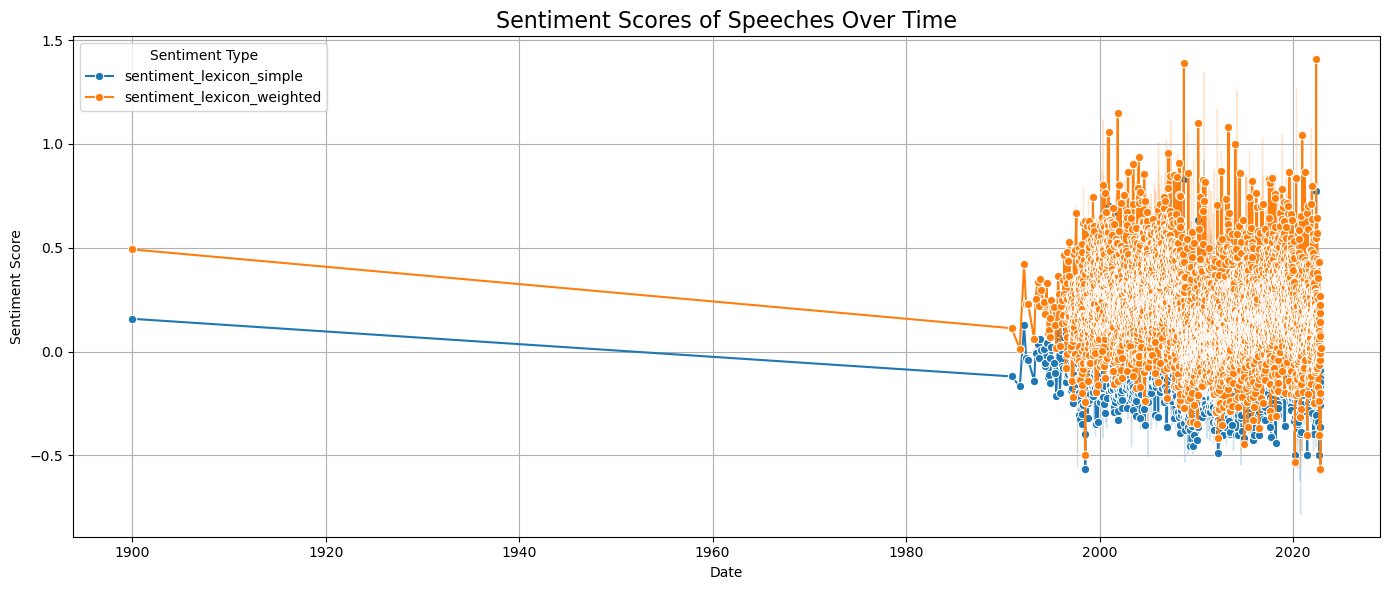

In [49]:
# Convert date column to datetime
speeches_sentiment['date'] = pd.to_datetime(speeches_sentiment['date'])

# Group by year and calculate average sentiment
# yearly_sentiment = speeches_sentiment.groupby(speeches_df['date'].dt.year)['sentiment_score'].mean().reset_index()

# Melt for seaborn
melted = speeches_sentiment.melt(
    id_vars='date',
    value_vars=['sentiment_lexicon_simple', 'sentiment_lexicon_weighted'],
    var_name='Sentiment Type',
    value_name='Score'
)

# Plot
plt.figure(figsize=(14,6))
sns.lineplot(data=melted, x='date', y='Score', hue='Sentiment Type', marker='o')
plt.title('Sentiment Scores of Speeches Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.grid(True)
plt.tight_layout()
plt.show()

##### Looks like we have data error some speeches have dates in the early 1900s.

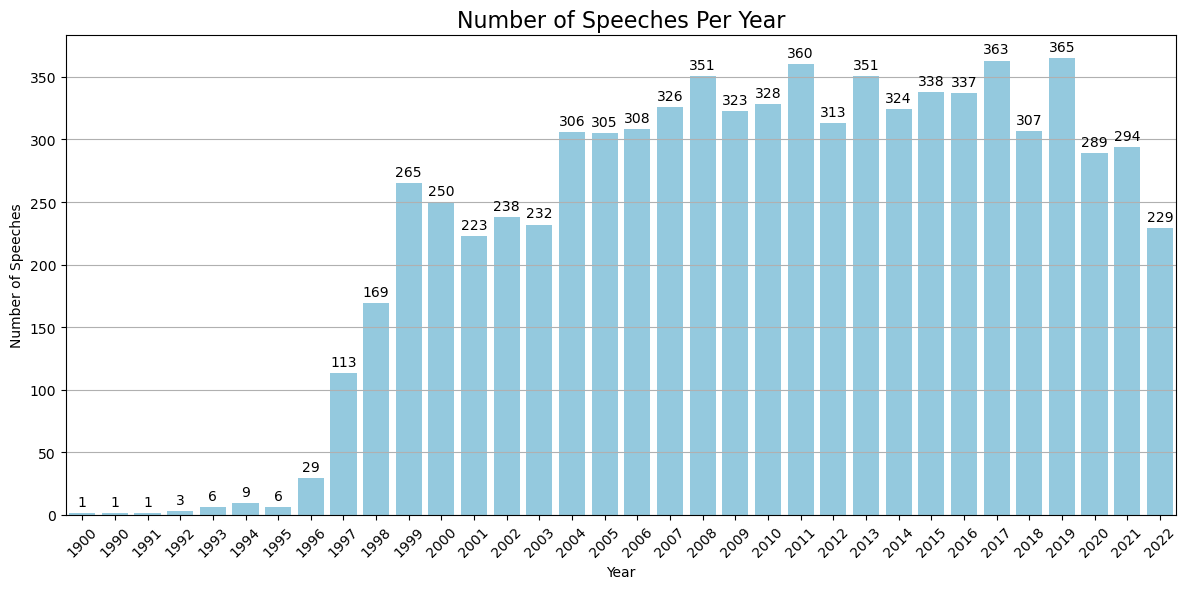

In [51]:
# Check speeches per year and clean up dataset
speeches_sentiment['year'] = speeches_sentiment['date'].dt.year

# Group by year and count speeches
yearly_counts = speeches_sentiment.groupby('year').size().reset_index(name='speech_count')

#Plot
plt.figure(figsize=(12,6))
ax = sns.barplot(data=yearly_counts, x='year', y='speech_count', color='skyblue')

plt.title('Number of Speeches Per Year', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Number of Speeches')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

# Add labels on top of bars
for i in ax.containers:
    ax.bar_label(i, label_type='edge', padding=3, fontsize=10)

plt.show()

In [52]:
speeches_sentiment.head(10)

reference    country       date                               title  \
0  r901128a_BOA  australia 1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia 1991-10-03                                       
2  r920314a_BOA  australia 1992-03-14                                       
3  r920529a_BOA  australia 1992-05-29                                       
4  r920817a_BOA  australia 1992-08-17                                       
5  r930331a_BOA  australia 1993-03-31                                       
6  r930520a_BOA  australia 1993-05-20                                       
7  r930804a_BOA  australia 1993-08-04                                       
8  r930921a_BOA  australia 1993-09-21                                       
9  r931110a_BOA  australia 1993-11-10                                       

   author  is_gov                                               text  \
0  fraser       0  They would no doubt argue that to have two obj...   
1  fraser       0  Today I wish to talk about real interest rates...   
2  fraser       0  I welcome this opportunity to talk about prosp...   
3  fraser       0  It is a pleasure to have this opportunity to a...   
4  fraser       0  As a long-time fan of Don Sanders, I am deligh...   
5  fraser       0  I have been looking forward to this opportunit...   
6  fraser       0  Economic growth is usually viewed from a short...   
7  fraser       0  Vision' is not one of my favourite words: it c...   
8  fraser       0  I welcome this opportunity to mention some dev...   
9  fraser       0  Australia, like other countries, has a number ...   

                                           text_norm  \
0  they would no doubt argue that to have two obj...   
1  today i wish to talk about real interest rates...   
2  i welcome this opportunity to talk about prosp...   
3  it is a pleasure to have this opportunity to a...   
4  as a long-time fan of don sanders, i am deligh...   
5  i have been looking forward to this opportunit...   
6  economic growth is usually viewed from a short...   
7  vision' is not one of my favourite words: it c...   
8  i welcome this opportunity to mention some dev...   
9  australia, like other countries, has a number ...   

                                        text_cleaned  \
0  would doubt argue two objectives like trying c...   
1  today wish talk real interest rates mainly his...   
2  welcome opportunity talk prospects banks austr...   
3  pleasure opportunity address influential gathe...   
4  long time fan sanders delighted participating ...   
5  looking forward opportunity speak abe one thin...   
6  economic growth usually viewed short term pers...   
7  vision not one favourite words surrealist over...   
8  welcome opportunity mention developments austr...   
9  australia like countries number economic probl...   

                                      text_tokenised  ... positive  \
0  ['would', 'doubt', 'argue', 'two', 'objectives...  ...       58   
1  ['today', 'wish', 'talk', 'real', 'interest', ...  ...       28   
2  ['welcome', 'opportunity', 'talk', 'prospects'...  ...       67   
3  ['pleasure', 'opportunity', 'address', 'influe...  ...       56   
4  ['long', 'time', 'fan', 'sanders', 'delighted'...  ...       62   
5  ['looking', 'forward', 'opportunity', 'speak',...  ...       62   
6  ['economic', 'growth', 'usually', 'viewed', 's...  ...       82   
7  ['vision', 'not', 'one', 'favourite', 'words',...  ...       57   
8  ['welcome', 'opportunity', 'mention', 'develop...  ...       51   
9  ['australia', 'like', 'countries', 'number', '...  ...       54   

  uncertainty  litigious  strong  weak  constraining  word_count_sentiment  \
0          32          5      10    15            13                   217   
1          35          2       3    16            12                   149   
2          33          8      11    16            13                   191   
3          43          6       7    20          

In [53]:
# Filter data betyween 1999 -2022
speeches_sentiment_filtered = speeches_sentiment[
    (speeches_sentiment['year'] >= 1999) & (speeches_sentiment['year'] <= 2022)
]

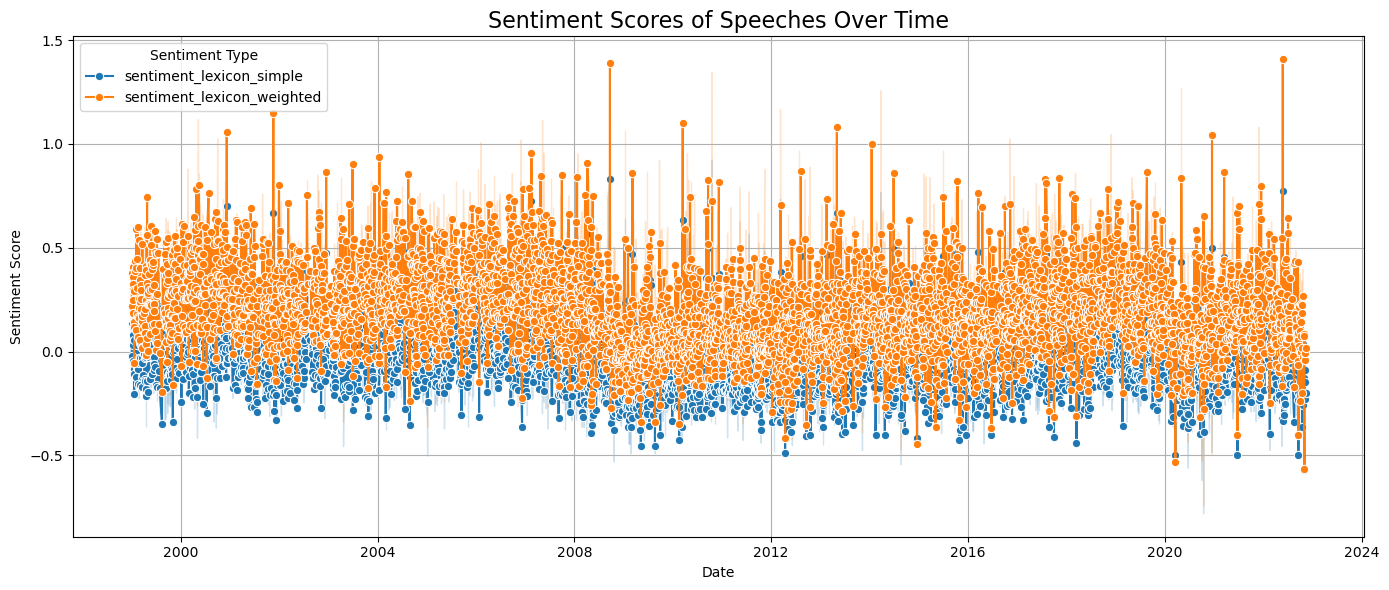

In [54]:
# Melt for seaborn
melted_f = speeches_sentiment_filtered.melt(
    id_vars='date',
    value_vars=['sentiment_lexicon_simple', 'sentiment_lexicon_weighted'],
    var_name='Sentiment Type',
    value_name='Score'
)

# Plot
plt.figure(figsize=(14,6))
sns.lineplot(data=melted_f, x='date', y='Score', hue='Sentiment Type', marker='o')
plt.title('Sentiment Scores of Speeches Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.grid(True)
plt.tight_layout()
plt.show()

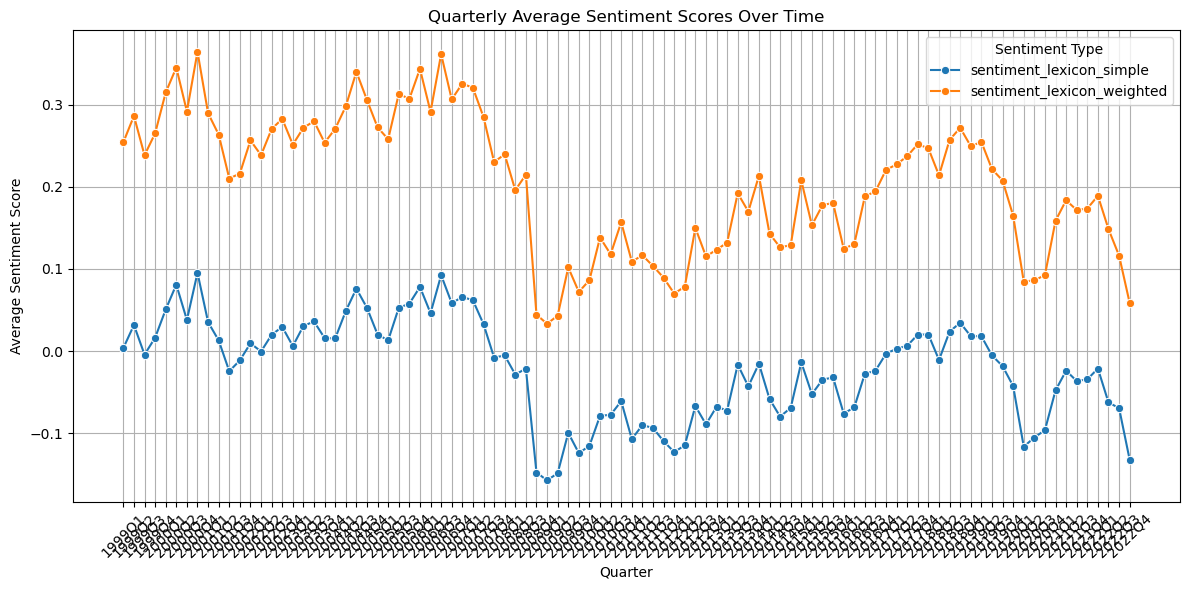

In [55]:
# Make a copy before creating quarterly and yearly aggregates and secure that the date is in the right format
speeches_sentiment_filtered = speeches_sentiment_filtered.copy()
speeches_sentiment_filtered['date'] = pd.to_datetime(speeches_sentiment_filtered['date'])

# Generate M, Q, Y columns
speeches_sentiment_filtered['year'] = speeches_sentiment_filtered['date'].dt.year
speeches_sentiment_filtered['quarter'] = speeches_sentiment_filtered['date'].dt.to_period('Q').astype(str)
speeches_sentiment_filtered['month'] = speeches_sentiment_filtered['date'].dt.to_period('M').astype(str)

# Quarterly averages
quarterly_sentiment = speeches_sentiment_filtered.groupby('quarter')[
    ['sentiment_lexicon_simple', 'sentiment_lexicon_weighted']
].mean().reset_index()

quarterly_melted = quarterly_sentiment.melt(
    id_vars='quarter', 
    var_name='Sentiment Type', 
    value_name='Score'
)

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(
    data=quarterly_melted, 
    x='quarter', 
    y='Score', 
    hue='Sentiment Type', 
    marker='o'
)
plt.title('Quarterly Average Sentiment Scores Over Time')
plt.xlabel('Quarter')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

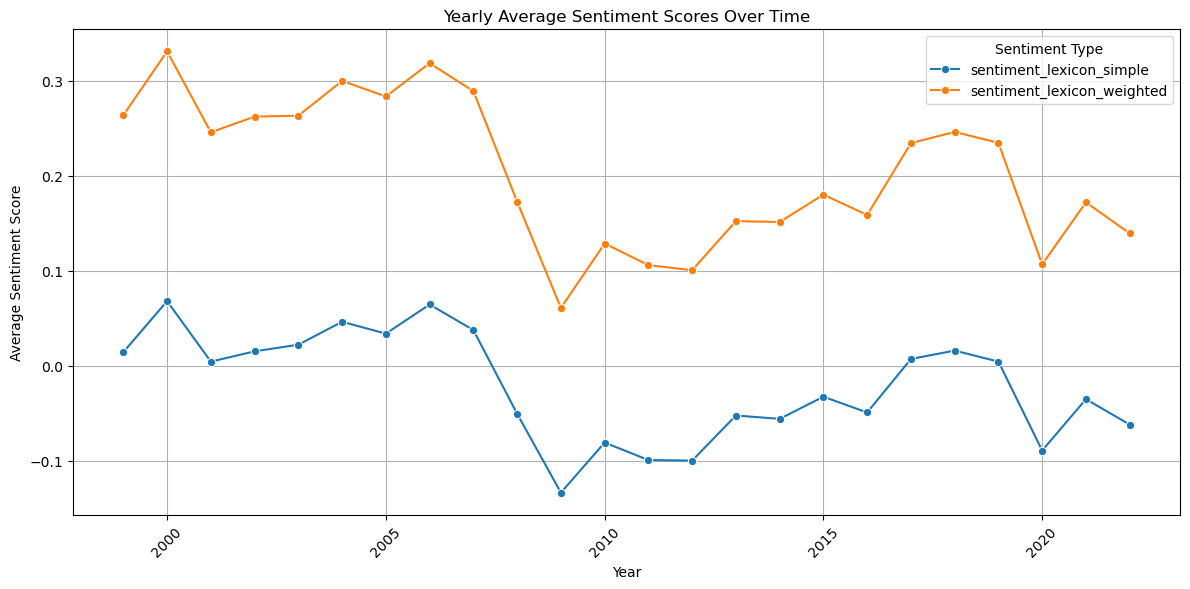

In [56]:
# Yearly averages
yearly_sentiment = speeches_sentiment_filtered.groupby('year')[
    ['sentiment_lexicon_simple', 'sentiment_lexicon_weighted']
].mean().reset_index()

yearly_melted = yearly_sentiment.melt(
    id_vars='year', 
    var_name='Sentiment Type', 
    value_name='Score'
)

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(
    data=yearly_melted, 
    x='year', 
    y='Score', 
    hue='Sentiment Type', 
    marker='o'
)
plt.title('Yearly Average Sentiment Scores Over Time')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#####  On large scale it seems that the weighted and simple sentiment scores follow the same trend

### 7. Check and group countries

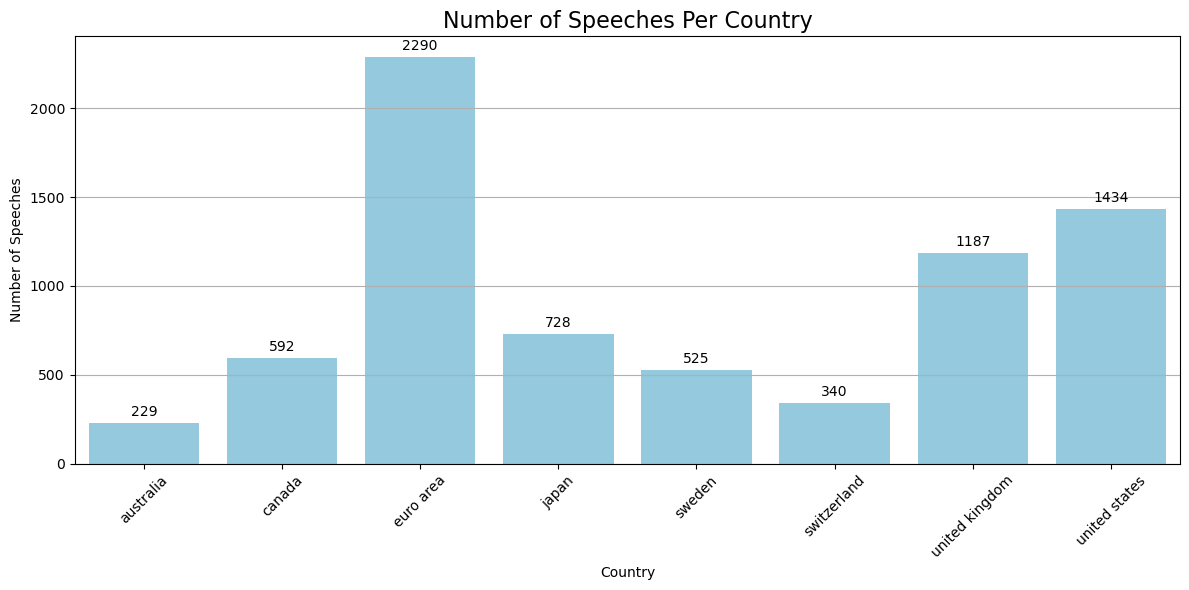

In [59]:
# Group by country and count speeches
country_counts = speeches_sentiment_filtered.groupby('country').size().reset_index(name='speech_count')

#Plot
plt.figure(figsize=(12,6))
ax = sns.barplot(data=country_counts, x='country', y='speech_count', color='skyblue')

plt.title('Number of Speeches Per Country', fontsize=16)
plt.xlabel('Country')
plt.ylabel('Number of Speeches')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

# Add labels on top of bars
for i in ax.containers:
    ax.bar_label(i, label_type='edge', padding=3, fontsize=10)

plt.show()

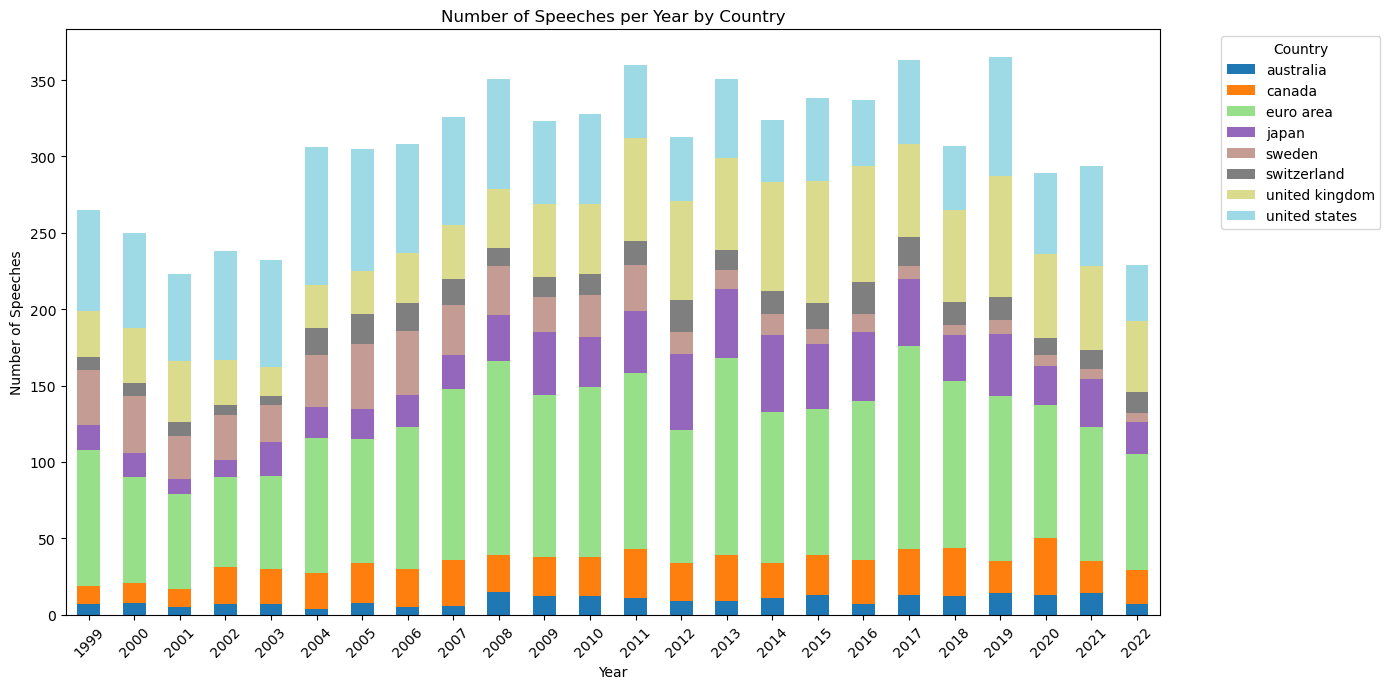

country  australia  canada  euro area  japan  sweden  switzerland  \
year                                                                
1999             7      12         89     16      36            9   
2000             8      13         69     16      37            9   
2001             5      12         62     10      28            9   
2002             7      24         59     11      30            6   
2003             7      23         61     22      24            6   
2004             4      23         89     20      34           18   
2005             8      26         81     20      42           20   
2006             5      25         93     21      42           18   
2007             6      30        112     22      33           17   
2008            15      24        127     30      32           12   
2009            12      26        106     41      23           13   
2010            12      26        111     33      27           14   
2011            11      32        115     41      30           16   
2012             9      25         87     50      14           21   
2013             9      30        129     45      13           13   
2014            11      23         99     50      14           15   
2015            13      26         96     42      10           17   
2016             7      29        104     45      12           21   
2017            13      30        133     44       8           19   
2018            12      32        109     30       7           15   
2019            14      21        108     41       9           15   
2020            13      37         87     26       7           11   
2021            14      21         88     31       7           12   

country  united kingdom  united states  
year                                    
1999                 30             66  
2000                 36             62  
2001                 40             57  
2002                 30             71  
2003                 19             70  
2004                 28             90  
2005                 28             80  
2006                 33             71  
2007                 35             71  
2008                 39             72  
2009                 48             54  
2010                 46             59  
2011                 67             48  
2012                 65             42  
2013                 60             52  
2014                 71             41  
2015                 80             54  
2016                 76             43  
2017                 61             55  
2018                 60             42  
2019                 79             78  
2020                 55             53  
2021                 55             66

In [60]:
# Check speech counts per country per year
speech_counts = speeches_sentiment_filtered.groupby(['year', 'country']).size().reset_index(name='speech_count')

# Pivot to have countries as columns => wan to visualize on stacked bar chart
speech_pivot = speech_counts.pivot(index='year', columns='country', values='speech_count').fillna(0)

# Plot stacked bar chart
speech_pivot.plot(kind='bar', stacked=True, figsize=(14,7), colormap='tab20')

plt.title('Number of Speeches per Year by Country')
plt.xlabel('Year')
plt.ylabel('Number of Speeches')
plt.xticks(rotation=45)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
speech_pivot.head(23)

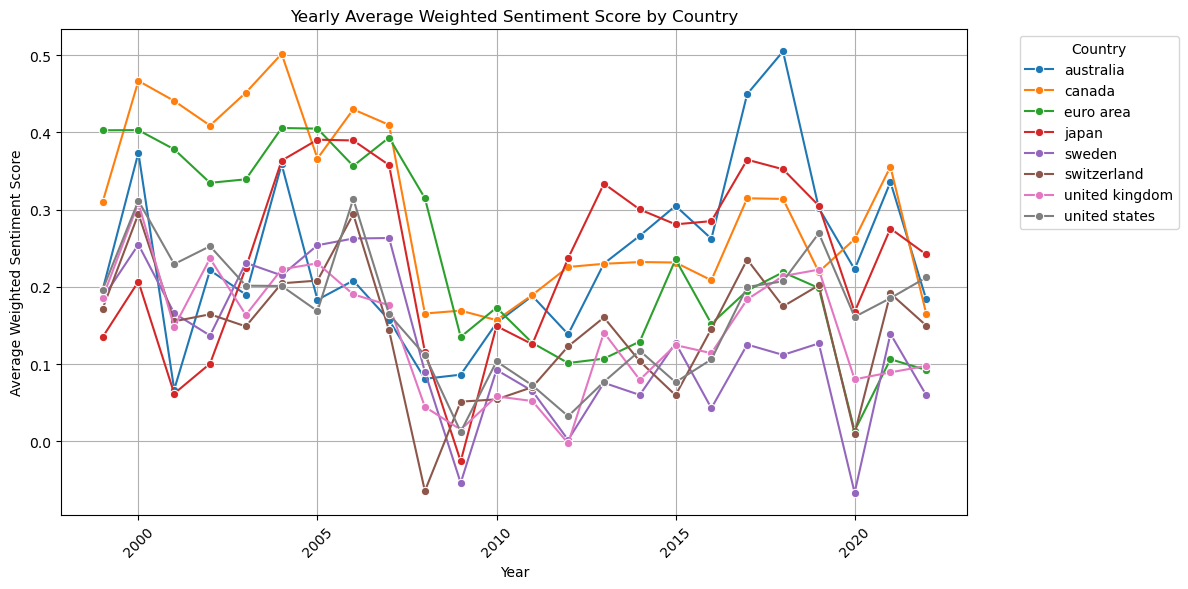

In [61]:
# Yearly average by country
weighted_sentiment = speeches_sentiment_filtered.groupby(['year', 'country'])[
    'sentiment_lexicon_weighted'
].mean().reset_index()

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(
    data=weighted_sentiment,
    x='year',
    y='sentiment_lexicon_weighted',
    hue='country',
    marker='o'
)
plt.title('Yearly Average Weighted Sentiment Score by Country')
plt.xlabel('Year')
plt.ylabel('Average Weighted Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Different years and countries have different amount of speeches therefore using the average of weighted (or simple) sentiment score that is calculated on speech level is not correct -> disproportionate comparison

In [63]:
speeches_sentiment_filtered.head(5)

reference    country       date      title      author  is_gov  \
55  r990311a_BOA  australia 1999-03-11             macfarlane       1   
56  r990521a_BOA  australia 1999-05-21             macfarlane       1   
57  r990617a_BOA  australia 1999-06-17             macfarlane       1   
58  r990729a_BOA  australia 1999-07-29             macfarlane       1   
59  r991027a_BOA  australia 1999-10-27             macfarlane       1   

                                                 text  \
55  Last time I spoke to a group like this in Toky...   
56  It is a pleasure to be in Hong Kong talking to...   
57  Governor, in testimony to the House of was rel...   
58  The following is the text of the R.C. Mills Me...   
59  The following is the text of the Chris Higgins...   

                                            text_norm  \
55  last time i spoke to a group like this in toky...   
56  it is a pleasure to be in hong kong talking to...   
57  governor, in testimony to the house of was rel...   
58  the following is the text of the r.c. mills me...   
59  the following is the text of the chris higgins...   

                                         text_cleaned  \
55  last time spoke group like tokyo september 199...   
56  pleasure hong kong talking clsa investors foru...   
57  governor testimony house released 6 may 1999 t...   
58  following text r c mills memorial lecture deli...   
59  following text chris higgins delivered honour ...   

                                       text_tokenised  ... litigious strong  \
55  ['last', 'time', 'spoke', 'group', 'like', 'to...  ...         1      3   
56  ['pleasure', 'hong', 'kong', 'talking', 'clsa'...  ...         1      7   
57  ['governor', 'testimony', 'house', 'released',...  ...         3      1   
58  ['following', 'text', 'r', 'c', 'mills', 'memo...  ...        21     11   
59  ['following', 'text', 'chris', 'higgins', 'del...  ...         4      6   

    weak  constraining  word_count_sentiment  sentiment_lexicon_simple  \
55    11             2                   109                 -0.073394   
56     8             1                   104                  0.115385   
57    24             4                   200                 -0.065000   
58    21            17                   359                 -0.097493   
59    11             2                   153                  0.143791   

    sentiment_lexicon_weighted  year  quarter    month  
55                    0.192661  1999   1999Q1  1999-03  
56                    0.479808  1999   1999Q2  1999-05  
57                    0.171000  1999   1999Q2  1999-06  
58                    0.111421  1999   1999Q3  1999-07  
59                    0.467320  1999   1999Q4  1999-10  

[5 rows x 27 columns]

### Method 1 => same result as above

In [65]:
# Calculate weighted sentiment score for catgory aggregation
# Normalize by word count
for category in category_weights.keys():
    speeches_sentiment_filtered[f'{category}_norm'] = speeches_sentiment_filtered[category] / speeches_sentiment_filtered['word_count_sentiment'] * 100
    
# Calculate weighted score
speeches_sentiment_filtered['weighted_sentiment'] = sum(speeches_sentiment_filtered[f'{category}_norm'] * weight 
                               for category, weight in category_weights.items())

# Function to aggregate by any time period and entity
def aggregate_sentiment(df, time_period='quarter', entity='country'):
    """
    Aggregate sentiment by specified time period and entity.
    
    Parameters:
    - df: DataFrame with sentiment scores
    - time_period: Column to use for time aggregation ('year', 'quarter', 'month')
    - entity: Column to use for entity aggregation ('country', 'author')
    
    Returns:
    - DataFrame with aggregated sentiment scores
    """
    # For quarter, use the quarter column directly
    group_cols = [entity]
    
    if time_period == 'year':
        group_cols.append('year')
    elif time_period == 'quarter':
        group_cols.append('quarter')
    elif time_period == 'month':
        group_cols.append('month')
    
    # Calculate averages and counts
    agg_df = df.groupby(group_cols).agg({
        'weighted_sentiment': 'mean',
        'reference': 'count'  # Count number of speeches
    }).reset_index()
    
    # Rename the count column
    agg_df.rename(columns={'reference': 'speech_count'}, inplace=True)
    
    return agg_df

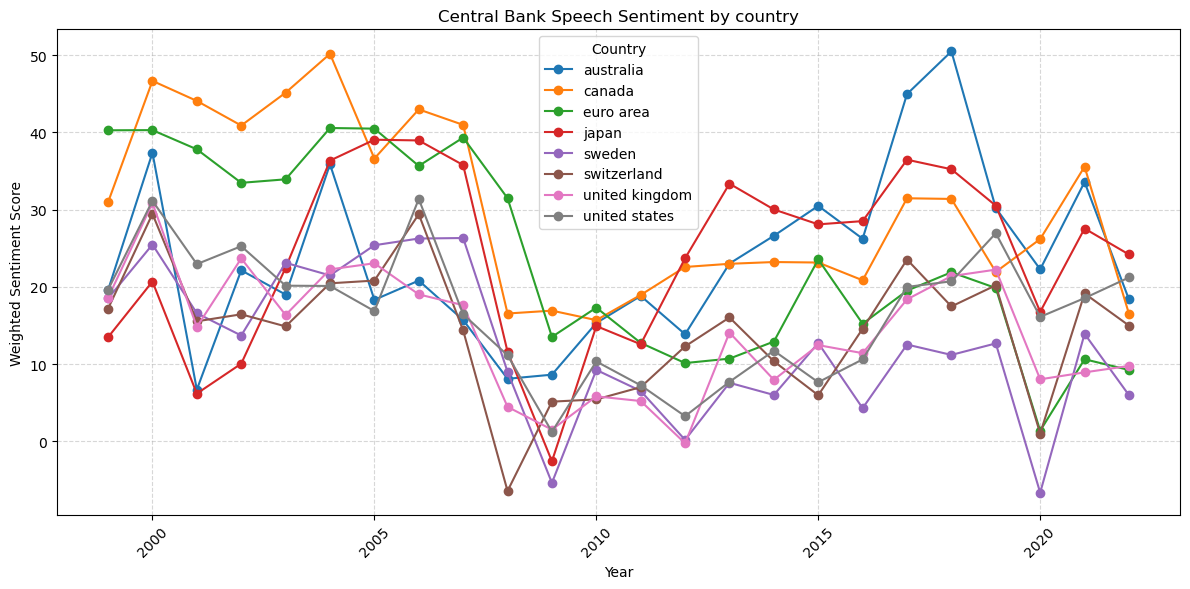

In [66]:
#Plot
# Simple plotting function
def plot_sentiment_trends(df, entity_col='country', time_col='year'):
    """
    Plot sentiment trends by entity over time.
    
    Parameters:
    - df: DataFrame with aggregated sentiment data
    - entity_col: Column containing entities to compare (country, author)
    - time_col: Column to use for time axis (year, quarter, month)
    """
    plt.figure(figsize=(12, 6))
    entities = df[entity_col].unique()
    for entity in entities:
        # Filter data for this entity
        entity_data = df[df[entity_col] == entity]
        
        # Sort by time
        entity_data = entity_data.sort_values(by=time_col)
        
        # Plot this entity's line
        plt.plot(entity_data[time_col], 
                 entity_data['weighted_sentiment'], 
                 marker='o', 
                 label=entity)
    
    # Set labels and formatting
    plt.xlabel(time_col.capitalize())
    plt.ylabel('Weighted Sentiment Score')
    plt.title(f'Central Bank Speech Sentiment by {entity_col}')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45)
    
    # Add legend AFTER plotting the lines
    plt.legend(title=entity_col.capitalize())
    
    # Ensure everything fits
    plt.tight_layout()
    
    return plt

# Revised by year and country sentiment 
yearly_country = aggregate_sentiment(speeches_sentiment_filtered, 'year', 'country')

plot_sentiment_trends(yearly_country, 'country', 'year')
plt.show()

### Method 2 The score is a weighted average of sentiment-related word categories, normalized by the number of sentiment-bearing words (word_count_sentiment) in each group. => Not huge differnce but more nuanced for sentiment comparison

In [68]:
# Weighted sentiment score 2 - compound
def compute_weighted_sentiment_grouped(df, groupby_cols, weights, normalize=True):
    """
    Create aggregated sentiment score based on weighted average of sentiment-related word categories, normalized by the number of sentiment-bearing words
    
    Parameters:
    - df: DataFrame with sentiment data
    - groupby_cols: Columns to group by sentiment scores (country, author, year, quarter, month)
    - weights: Weights per sentiment category
    """
    # Aggregate all category counts
    agg_dict = {cat: 'sum' for cat in weights if cat in df.columns}
    agg_dict['word_count_sentiment'] = 'sum'

    grouped = df.groupby(groupby_cols).agg(agg_dict).reset_index()

    # Compute weighted score
    weighted_score_2 = sum(
        grouped[cat] * weight for cat, weight in weights.items() if cat in grouped.columns
    )
    
    if normalize:
        grouped['sentiment_weighted_2'] = weighted_score_2 / grouped['word_count_sentiment']
    else:
        grouped['sentiment_weighted_2'] = weighted_score_2
    
    return grouped

In [69]:
# New weighted sentiment per country per year
country_year_sentiment = compute_weighted_sentiment_grouped(
    speeches_sentiment_filtered,
    groupby_cols=['country', 'year'],
    weights=category_weights
)
country_year_sentiment. head(15)

country  year  negative  positive  uncertainty  litigious  strong  weak  \
0   australia  1999       398       330          199         35      37    89   
1   australia  2000       351       407          231         30      52   110   
2   australia  2001       352       184          201         12      38   101   
3   australia  2002       326       261          186         24      48    89   
4   australia  2003       682       446          444         80      59   187   
5   australia  2004       186       225          119         23      28    53   
6   australia  2005       333       277          161         49      31    84   
7   australia  2006       281       262          185         28      25    86   
8   australia  2007       433       307          353         30      30   138   
9   australia  2008      1041       600          666        103      67   293   
10  australia  2009       912       623          495        123      59   219   
11  australia  2010       750       495          504        118      55   253   
12  australia  2011      1179       780          819        148     109   390   
13  australia  2012       624       484          365         91      51   179   
14  australia  2013       406       397          319        120      30   159   

    constraining  word_count_sentiment  sentiment_weighted_2  
0             35                  1123              0.189047  
1             25                  1206              0.348425  
2             24                   912              0.062829  
3             34                   968              0.203926  
4             42                  1940              0.113814  
5             13                   647              0.359660  
6             46                   981              0.173700  
7             32                   899              0.231257  
8             58                  1349              0.131282  
9             92                  2862              0.060307  
10            94                  2525              0.098178  
11            72                  2247              0.108011  
12            99                  3524              0.123212  
13            82                  1876              0.150213  
14            63                  1494              0.215730

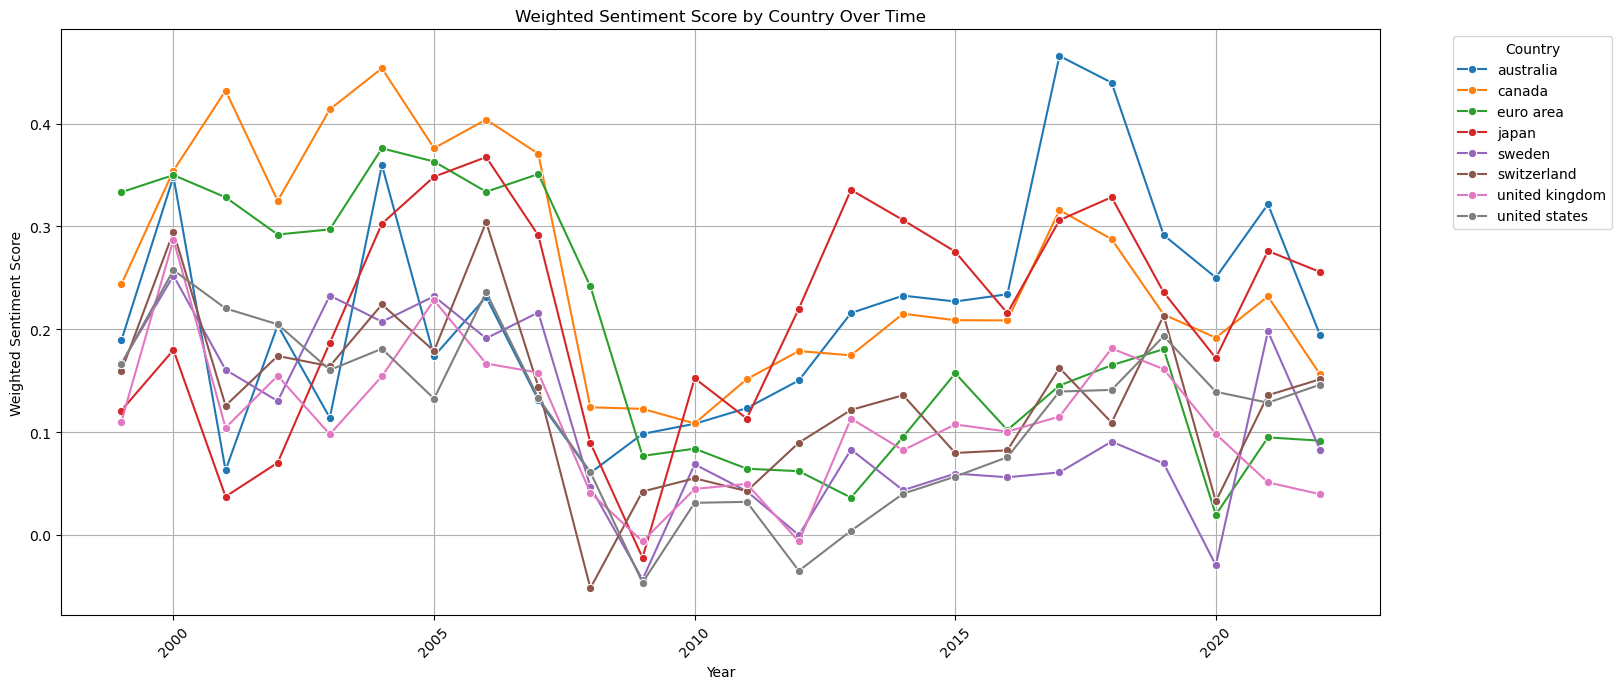

In [70]:
# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=country_year_sentiment,
    x='year',
    y='sentiment_weighted_2',
    hue='country',
    marker='o'
)

plt.title('Weighted Sentiment Score by Country Over Time')
plt.xlabel('Year')
plt.ylabel('Weighted Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

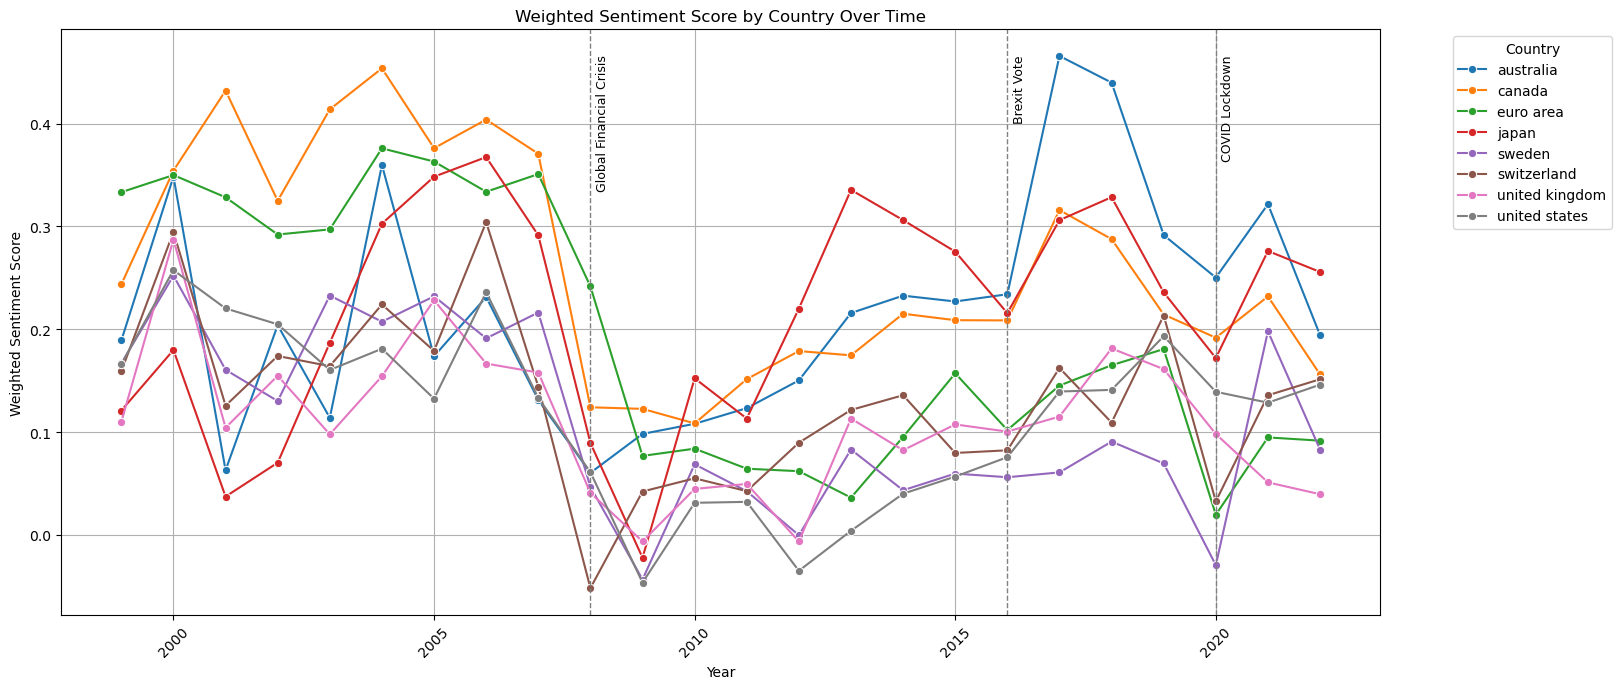

In [71]:
# Event list
events = [
    ("Global Financial Crisis", "2008-09"),
    ("Brexit Vote", "2016-06"),
    ("COVID Lockdown", "2020-03")
]

# Convert to year as integer for positioning
event_annotations = [(label, pd.to_datetime(date).year) for label, date in events]

# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=country_year_sentiment,
    x='year',
    y='sentiment_weighted_2',
    hue='country',
    marker='o'
)

# Add vertical event lines
for label, year in event_annotations:
    plt.axvline(x=year, color='gray', linestyle='--', linewidth=1)
    plt.text(
        x=year + 0.1,  # Slightly offset to avoid overlapping the line
        y=plt.ylim()[1] * 0.95,  # Near the top of the plot
        s=label,
        rotation=90,
        verticalalignment='top',
        fontsize=9,
        color='black'
    )

plt.title('Weighted Sentiment Score by Country Over Time')
plt.xlabel('Year')
plt.ylabel('Weighted Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

<Axes: xlabel='sentiment_category', ylabel='sentiment_weighted_2'>

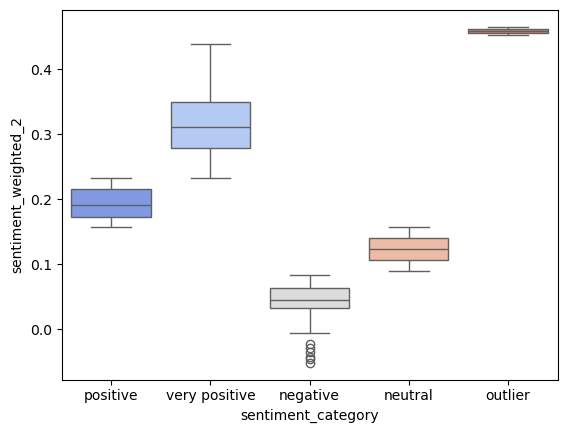

In [72]:
# Calculate IQR thresholds
Q1 = country_year_sentiment['sentiment_weighted_2'].quantile(0.25)
Q2 = country_year_sentiment['sentiment_weighted_2'].quantile(0.50)
Q3 = country_year_sentiment['sentiment_weighted_2'].quantile(0.75)
IQR = Q3 - Q1

# Classify sentiment categories\
def classify_sentiment(score):
    if score <= Q1 - 1.5 * IQR:
        return 'very negative'
    elif score <= Q1:
        return 'negative'
    elif score <= Q2:
        return 'neutral'
    elif score <= Q3:
        return 'positive'
    elif score <= Q3 + 1.5 * IQR:
        return 'very positive'
    else:
        return 'outlier'
        
country_year_sentiment['sentiment_category'] = country_year_sentiment['sentiment_weighted_2'].apply(classify_sentiment)

#Plot
sns.boxplot(
    x='sentiment_category', 
    y='sentiment_weighted_2', 
    data=country_year_sentiment, 
    hue='sentiment_category',        
    palette='coolwarm', 
    legend=False                     
)

In [73]:
import matplotlib.patches as mpatches

In [74]:
country_year_sentiment.head(15)

country  year  negative  positive  uncertainty  litigious  strong  weak  \
0   australia  1999       398       330          199         35      37    89   
1   australia  2000       351       407          231         30      52   110   
2   australia  2001       352       184          201         12      38   101   
3   australia  2002       326       261          186         24      48    89   
4   australia  2003       682       446          444         80      59   187   
5   australia  2004       186       225          119         23      28    53   
6   australia  2005       333       277          161         49      31    84   
7   australia  2006       281       262          185         28      25    86   
8   australia  2007       433       307          353         30      30   138   
9   australia  2008      1041       600          666        103      67   293   
10  australia  2009       912       623          495        123      59   219   
11  australia  2010       750       495          504        118      55   253   
12  australia  2011      1179       780          819        148     109   390   
13  australia  2012       624       484          365         91      51   179   
14  australia  2013       406       397          319        120      30   159   

    constraining  word_count_sentiment  sentiment_weighted_2  \
0             35                  1123              0.189047   
1             25                  1206              0.348425   
2             24                   912              0.062829   
3             34                   968              0.203926   
4             42                  1940              0.113814   
5             13                   647              0.359660   
6             46                   981              0.173700   
7             32                   899              0.231257   
8             58                  1349              0.131282   
9             92                  2862              0.060307   
10            94                  2525              0.098178   
11            72                  2247              0.108011   
12            99                  3524              0.123212   
13            82                  1876              0.150213   
14            63                  1494              0.215730   

   sentiment_category  
0            positive  
1       very positive  
2            negative  
3            positive  
4             neutral  
5       very positive  
6            positive  
7            positive  
8             neutral  
9            negative  
10            neutral  
11            neutral  
12            neutral  
13            neutral  
14           positive

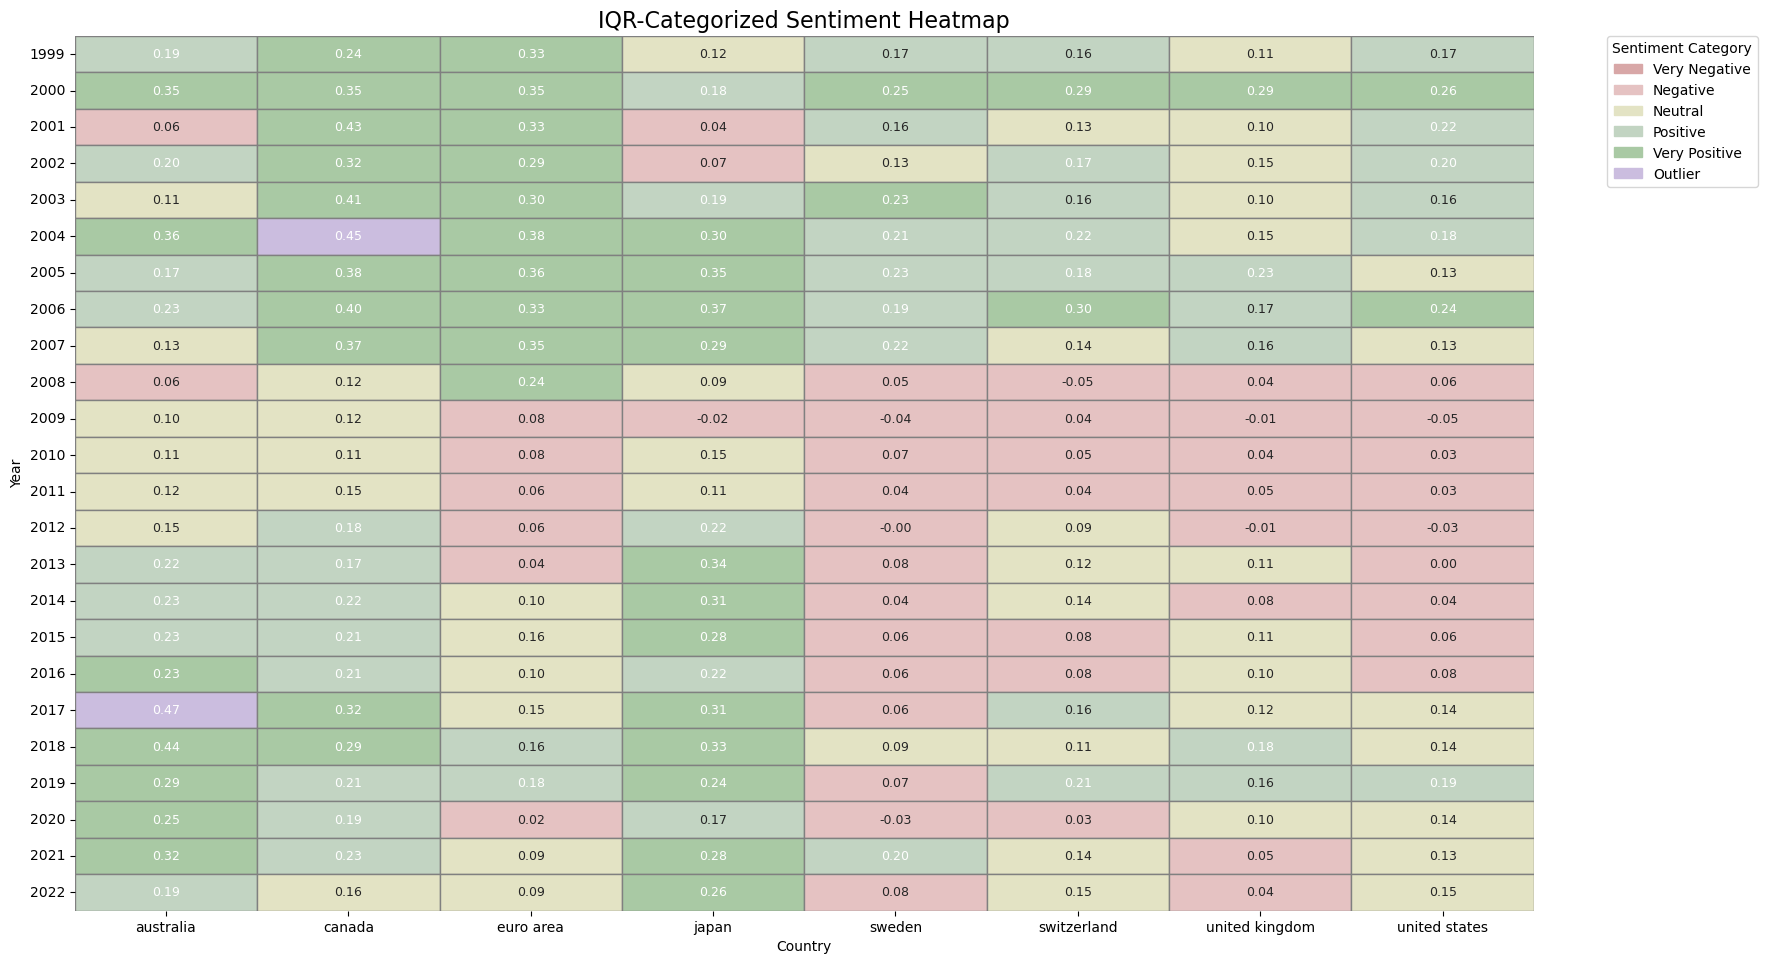

In [75]:
# Create heatmap 
country_year_sentiment['sentiment_category'] = country_year_sentiment['sentiment_weighted_2'].apply(classify_sentiment)

value_matrix = country_year_sentiment.pivot(index='year', columns='country', values='sentiment_weighted_2')
color_matrix = country_year_sentiment.pivot(index='year', columns='country', values='sentiment_category')

category_colors = {
    'very negative': '#d8a7a7',   # Muted rose
    'negative': '#e5c2c2',        # Pale blush
    'neutral': '#e3e3c4',         # Desaturated wheat
    'positive': '#c2d4c2',        # Pale olive green
    'very positive': '#a9c9a4',   # Soft moss green
    'outlier': '#cbbddf'          # Muted lavender
}

# Start plot
fig, ax = plt.subplots(figsize=(18, 10))

# Draw a blank heatmap (white tiles, no cmap)
sns.heatmap(
    value_matrix,
    annot=True,
    fmt=".2f",
    cbar=False,
    linewidths=0.5,
    linecolor='gray',
    square=False,
    annot_kws={"size": 9},
    mask=value_matrix.isna(),
    cmap='Greys',  # This is just for text alignment; actual tile color comes next
    ax=ax
)

# Manually color the background tiles
for y in range(value_matrix.shape[0]):
    for x in range(value_matrix.shape[1]):
        sentiment = color_matrix.iloc[y, x]
        if pd.notna(sentiment):
            rect = plt.Rectangle(
                (x, y), 1, 1,
                facecolor=category_colors.get(sentiment),
                edgecolor='gray'
            )
            ax.add_patch(rect)

# Fix ticks, labels, legend
ax.set_title('IQR-Categorized Sentiment Heatmap', fontsize=16)
ax.set_xlabel('Country')
ax.set_ylabel('Year')
plt.xticks(rotation=0)
plt.yticks(rotation=0)

# Add the legend
legend_patches = [
    mpatches.Patch(color=color, label=label.title()) 
    for label, color in category_colors.items()
]
plt.legend(
    handles=legend_patches,
    title="Sentiment Category",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)

plt.tight_layout(pad=2)
plt.show()

In [76]:
# Filter to only include selected countries
selected_countries = ['united kingdom', 'united states', 'japan', 'euro area']
filtered_df = country_year_sentiment[country_year_sentiment['country'].isin(selected_countries)]

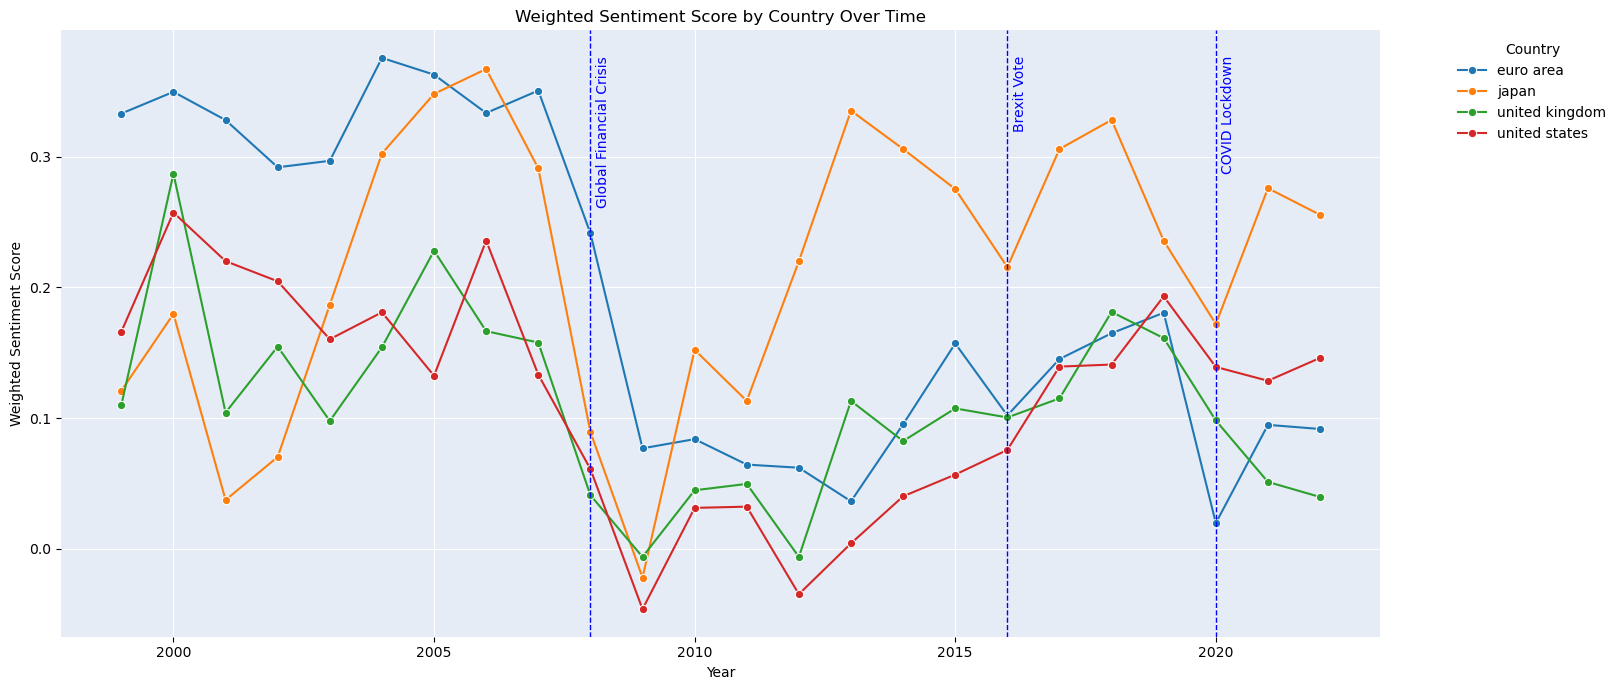

In [77]:
# Event list
events = [
    ("Global Financial Crisis", "2008-09"),
    ("Brexit Vote", "2016-06"),
    ("COVID Lockdown", "2020-03")
]

# Convert to year as integer for positioning
event_annotations = [(label, pd.to_datetime(date).year) for label, date in events]

# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=filtered_df,
    x='year',
    y='sentiment_weighted_2',
    hue='country',
    marker='o'
)

# Set the axes (plot area) facecolor to light gray
plt.gca().set_facecolor('#E5ECF6')

# Remove the gray border spines
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)

# Set grid lines to white
plt.grid(color='white')

# Keep figure (outside) background default (usually white)
plt.gcf().set_facecolor('white')

# Add vertical event lines
for label, year in event_annotations:
    plt.axvline(x=year, color='blue', linestyle='--', linewidth=1)
    plt.text(
        x=year + 0.1,  # Slightly offset to avoid overlapping the line
        y=plt.ylim()[1] * 0.95,  # Near the top of the plot
        s=label,
        rotation=90,
        verticalalignment='top',
        fontsize=10,
        color='blue'
    )

plt.title('Weighted Sentiment Score by Country Over Time')
plt.xlabel('Year')
plt.ylabel('Weighted Sentiment Score')
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left', facecolor ='white', frameon=False)
plt.savefig('weighted_sentiment_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

#### Rolling averages

In [79]:
# Rolling method on compound weighted sentiment
def rolling_weighted_sentiment_grouped(df, entity='country', window=3):
    """
    Apply rolling mean to pre-computed sentiment_weighted_2 by entity over time (monthly).
    
    Parameters:
    - df: DataFrame returned from compute_weighted_sentiment_grouped
    - entity: Column to group by (e.g., 'country', 'author')
    - window: Rolling window size in months
    
    Returns:
    - DataFrame with additional rolling sentiment column
    """
    # Ensure 'month' is datetime
    if not pd.api.types.is_datetime64_any_dtype(df['month']):
        df['month'] = pd.to_datetime(df['month'])

    # Sort by entity and month
    df_sorted = df.sort_values(by=[entity, 'month'])

    # Rolling sentiment
    df_sorted['sentiment_weighted_2_rolling'] = (
        df_sorted
        .groupby(entity)['sentiment_weighted_2']
        .transform(lambda x: x.rolling(window=window, min_periods=1).mean())
    )

    return df_sorted

In [80]:
# Sentiment by country, by month
country_month_sentiment = compute_weighted_sentiment_grouped(
    speeches_sentiment_filtered,
    groupby_cols=['country', 'month'],
    weights=category_weights
)
country_month_sentiment. head(15)

country    month  negative  positive  uncertainty  litigious  strong  \
0   australia  1999-03        42        34           16          1       3   
1   australia  1999-05        31        43           13          1       7   
2   australia  1999-06        66        53           49          3       1   
3   australia  1999-07       134        99           56         21      11   
4   australia  1999-10        42        64           24          4       6   
5   australia  1999-11        83        37           41          5       9   
6   australia  2000-02        78        72           36          3      10   
7   australia  2000-03        25        30           13         15       4   
8   australia  2000-05        46       113           40          3       9   
9   australia  2000-08        63        73           14          2       7   
10  australia  2000-09        38        34           43          2      11   
11  australia  2000-11        53        39           37          2       7   
12  australia  2000-12        48        46           48          3       4   
13  australia  2001-04        53        45           40          4      12   
14  australia  2001-05        54        37           39          3       5   

    weak  constraining  word_count_sentiment  sentiment_weighted_2  
0     11             2                   109              0.192661  
1      8             1                   104              0.479808  
2     24             4                   200              0.171000  
3     21            17                   359              0.111421  
4     11             2                   153              0.467320  
5     14             9                   198             -0.021717  
6     19             8                   226              0.252655  
7      7             2                    96              0.292708  
8     20             0                   231              0.668398  
9     11             4                   174              0.361494  
10    22             4                   154              0.303247  
11    12             1                   151              0.188742  
12    19             6                   174              0.244253  
13    14             4                   172              0.259884  
14    21             4                   163              0.151534

In [81]:
# 3 months rolling average of compound monthly scores
country_month_rolling = rolling_weighted_sentiment_grouped(
    country_month_sentiment,
    entity='country',
    window=3
)
country_month_rolling.head(5)

country      month  negative  positive  uncertainty  litigious  strong  \
0  australia 1999-03-01        42        34           16          1       3   
1  australia 1999-05-01        31        43           13          1       7   
2  australia 1999-06-01        66        53           49          3       1   
3  australia 1999-07-01       134        99           56         21      11   
4  australia 1999-10-01        42        64           24          4       6   

   weak  constraining  word_count_sentiment  sentiment_weighted_2  \
0    11             2                   109              0.192661   
1     8             1                   104              0.479808   
2    24             4                   200              0.171000   
3    21            17                   359              0.111421   
4    11             2                   153              0.467320   

   sentiment_weighted_2_rolling  
0                      0.192661  
1                      0.336234  
2                      0.281156  
3                      0.254076  
4                      0.249914

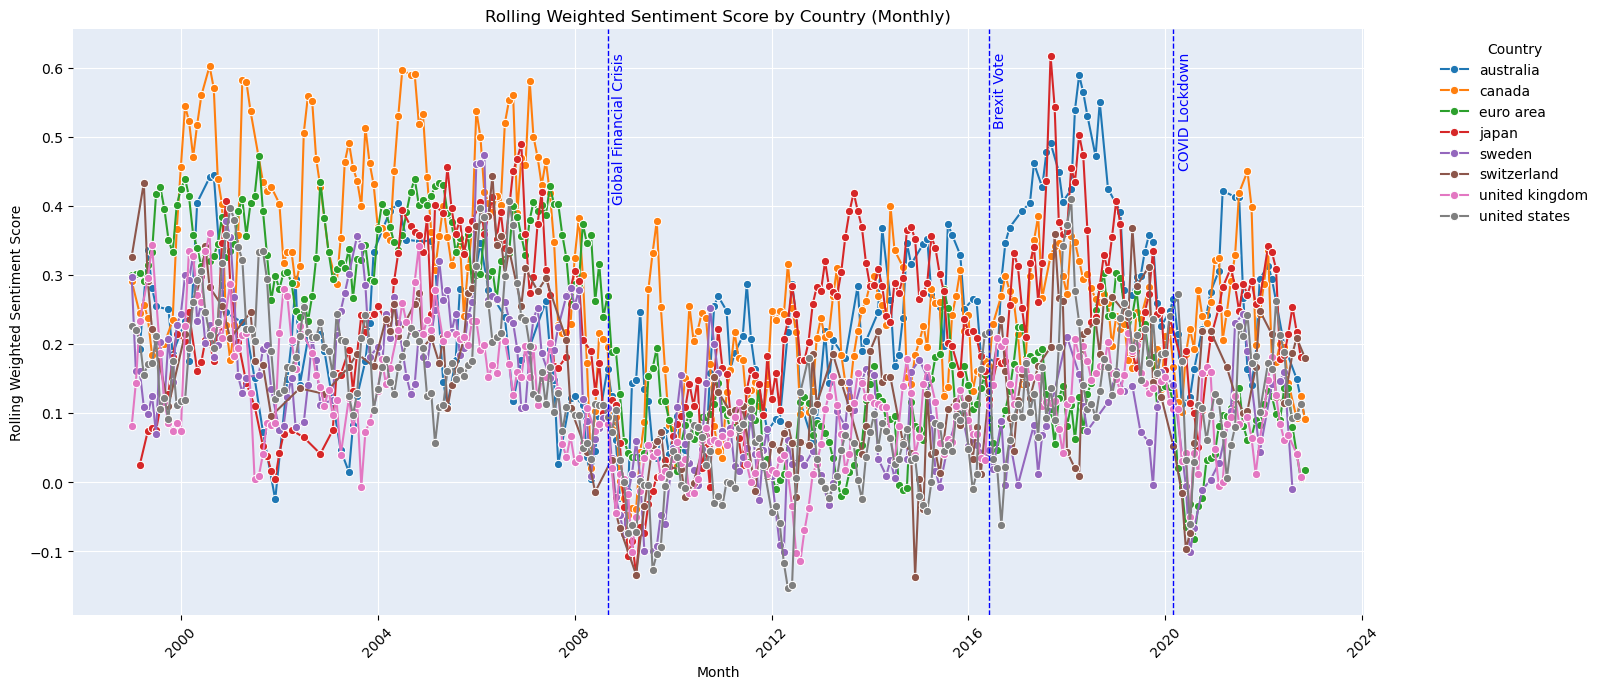

In [82]:
# Convert to datetime for monthly x-axis
event_annotations = [(label, pd.to_datetime(date)) for label, date in events]

# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=country_month_rolling,
    x='month',
    y='sentiment_weighted_2_rolling',
    hue='country',
    marker='o'
)

# Set ONLY the plot area facecolor to light gray
plt.gca().set_facecolor('#E5ECF6')

# Remove spines
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)

# Grid lines white
plt.grid(color='white')

# Outer figure background remains default white
plt.gcf().set_facecolor('white')

# Add vertical event lines
for label, date in event_annotations:
    plt.axvline(x=date, color='blue', linestyle='--', linewidth=1)
    plt.text(
        x=date + pd.DateOffset(months=1),  # Small offset
        y=plt.ylim()[1] * 0.95,
        s=label,
        rotation=90,
        verticalalignment='top',
        fontsize=10,
        color='blue'
    )

# Labels and formatting
plt.title('Rolling Weighted Sentiment Score by Country (Monthly)')
plt.xlabel('Month')
plt.ylabel('Rolling Weighted Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left', facecolor='white', frameon=False)
plt.savefig('rolling_weighted_sentiment_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

In [83]:
# Avg. 3 months rolling sentiment per year
country_month_rolling['year'] = country_month_rolling['month'].dt.year

yearly_3m_smoothed = (
    country_month_rolling
    .groupby(['country', 'year'])
    .agg(sentiment_3m_rolling=('sentiment_weighted_2_rolling', 'mean'))
    .reset_index()
)

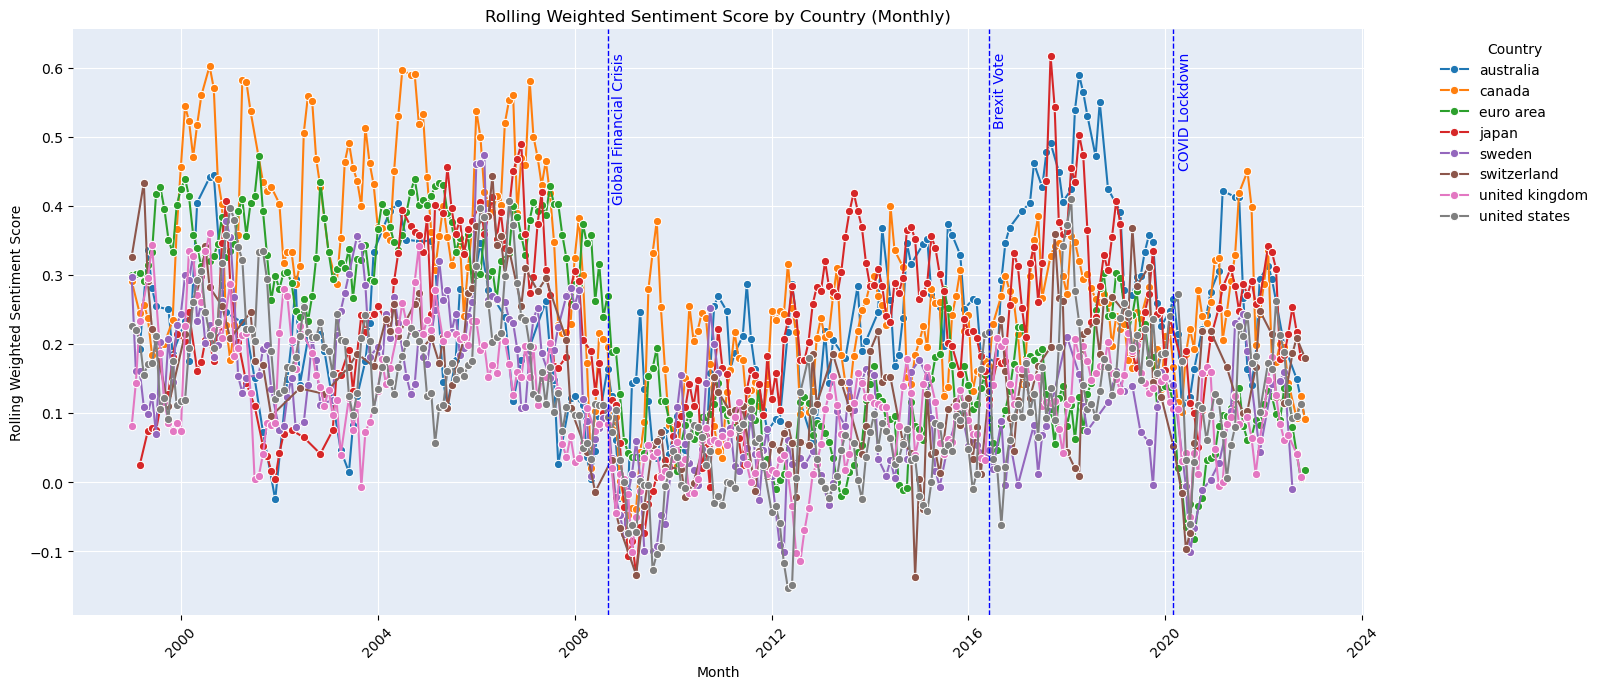

In [84]:
# Convert to datetime for monthly x-axis
event_annotations = [(label, pd.to_datetime(date)) for label, date in events]

# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=country_month_rolling,
    x='month',
    y='sentiment_weighted_2_rolling',
    hue='country',
    marker='o'
)

# Set ONLY the plot area facecolor to light gray
plt.gca().set_facecolor('#E5ECF6')

# Remove spines
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)

# Grid lines white
plt.grid(color='white')

# Outer figure background remains default white
plt.gcf().set_facecolor('white')

# Add vertical event lines
for label, date in event_annotations:
    plt.axvline(x=date, color='blue', linestyle='--', linewidth=1)
    plt.text(
        x=date + pd.DateOffset(months=1),  # Small offset
        y=plt.ylim()[1] * 0.95,
        s=label,
        rotation=90,
        verticalalignment='top',
        fontsize=10,
        color='blue'
    )

# Labels and formatting
plt.title('Rolling Weighted Sentiment Score by Country (Monthly)')
plt.xlabel('Month')
plt.ylabel('Rolling Weighted Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left', facecolor='white', frameon=False)
plt.savefig('rolling_weighted_sentiment_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

In [85]:
# Filter the DataFrame
filtered_3m_smoothed = yearly_3m_smoothed[yearly_3m_smoothed['country'].isin(selected_countries)]

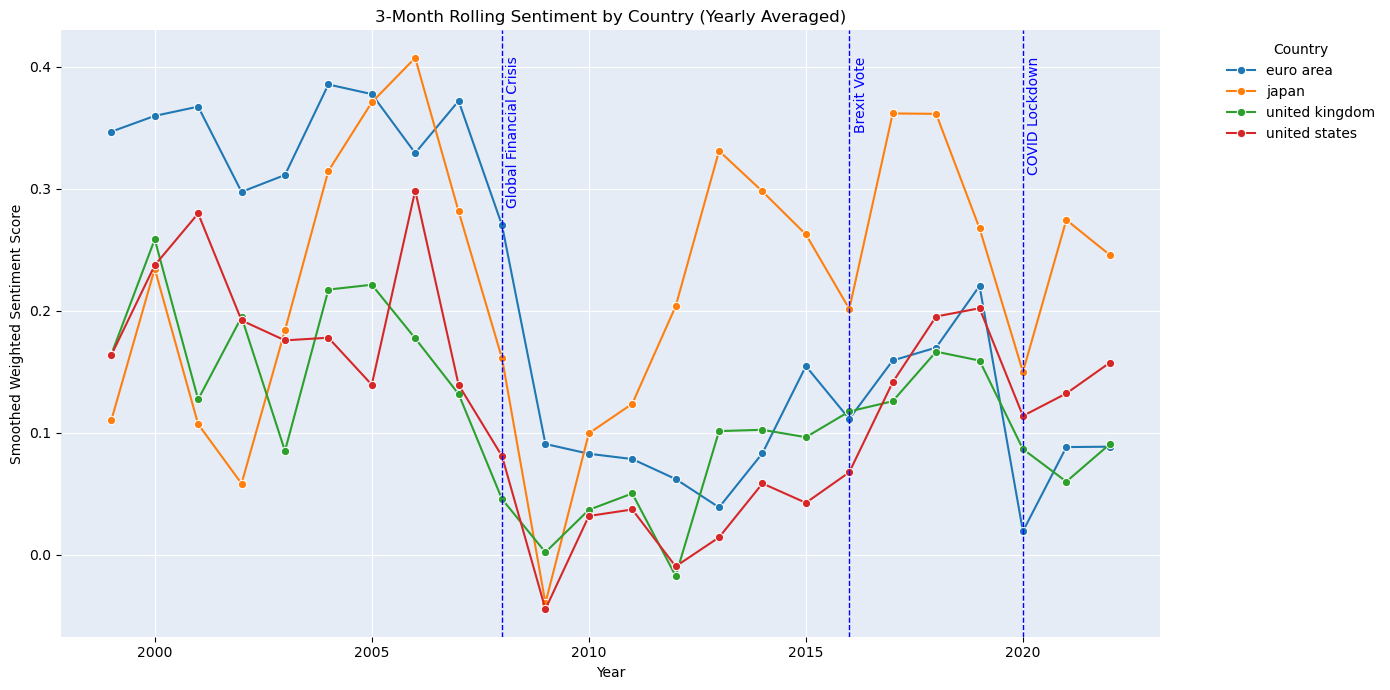

In [86]:
# Event list
events = [
    ("Global Financial Crisis", "2008-09"),
    ("Brexit Vote", "2016-06"),
    ("COVID Lockdown", "2020-03")
]
event_annotations = [(label, pd.to_datetime(date).year) for label, date in events]

# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=filtered_3m_smoothed,
    x='year',
    y='sentiment_3m_rolling',
    hue='country',
    marker='o'
)

# Style plot
ax = plt.gca()
ax.set_facecolor('#E5ECF6')
for spine in ax.spines.values():
    spine.set_visible(False)
plt.grid(color='white')
plt.gcf().set_facecolor('white')

# Add event lines
for label, year in event_annotations:
    plt.axvline(x=year, color='blue', linestyle='--', linewidth=1)
    plt.text(
        x=year + 0.1,
        y=plt.ylim()[1] * 0.95,
        s=label,
        rotation=90,
        verticalalignment='top',
        fontsize=10,
        color='blue'
    )

# Final polish
plt.title('3-Month Rolling Sentiment by Country (Yearly Averaged)')
plt.xlabel('Year')
plt.ylabel('Smoothed Weighted Sentiment Score')
plt.xticks(rotation=0)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left', facecolor='white', frameon=False)
plt.tight_layout()
plt.savefig('12_month_rolling_sentiment_yearly_avg.png', dpi=300, bbox_inches='tight')
plt.show()# Event list

In [87]:
# 12 months rolling average of compound monthly scores
country_month_rolling['month'] = pd.to_datetime(country_month_rolling['month'])

country_month_rolling = country_month_rolling.sort_values(by=['country', 'month'])

country_month_rolling['sentiment_12m_rolling'] = (
    country_month_rolling
    .groupby('country')['sentiment_weighted_2']
    .transform(lambda x: x.rolling(window=12, min_periods=1).mean())
)
country_month_rolling.head(5)

country      month  negative  positive  uncertainty  litigious  strong  \
0  australia 1999-03-01        42        34           16          1       3   
1  australia 1999-05-01        31        43           13          1       7   
2  australia 1999-06-01        66        53           49          3       1   
3  australia 1999-07-01       134        99           56         21      11   
4  australia 1999-10-01        42        64           24          4       6   

   weak  constraining  word_count_sentiment  sentiment_weighted_2  \
0    11             2                   109              0.192661   
1     8             1                   104              0.479808   
2    24             4                   200              0.171000   
3    21            17                   359              0.111421   
4    11             2                   153              0.467320   

   sentiment_weighted_2_rolling  year  sentiment_12m_rolling  
0                      0.192661  1999               0.192661  
1                      0.336234  1999               0.336234  
2                      0.281156  1999               0.281156  
3                      0.254076  1999               0.238722  
4                      0.249914  1999               0.284442

In [88]:
# Avg. rolling sentiment per year
country_month_rolling['year'] = country_month_rolling['month'].dt.year

yearly_smoothed = (
    country_month_rolling
    .groupby(['country', 'year'])
    .agg(sentiment_12m_rolling=('sentiment_12m_rolling', 'mean'))
    .reset_index()
)

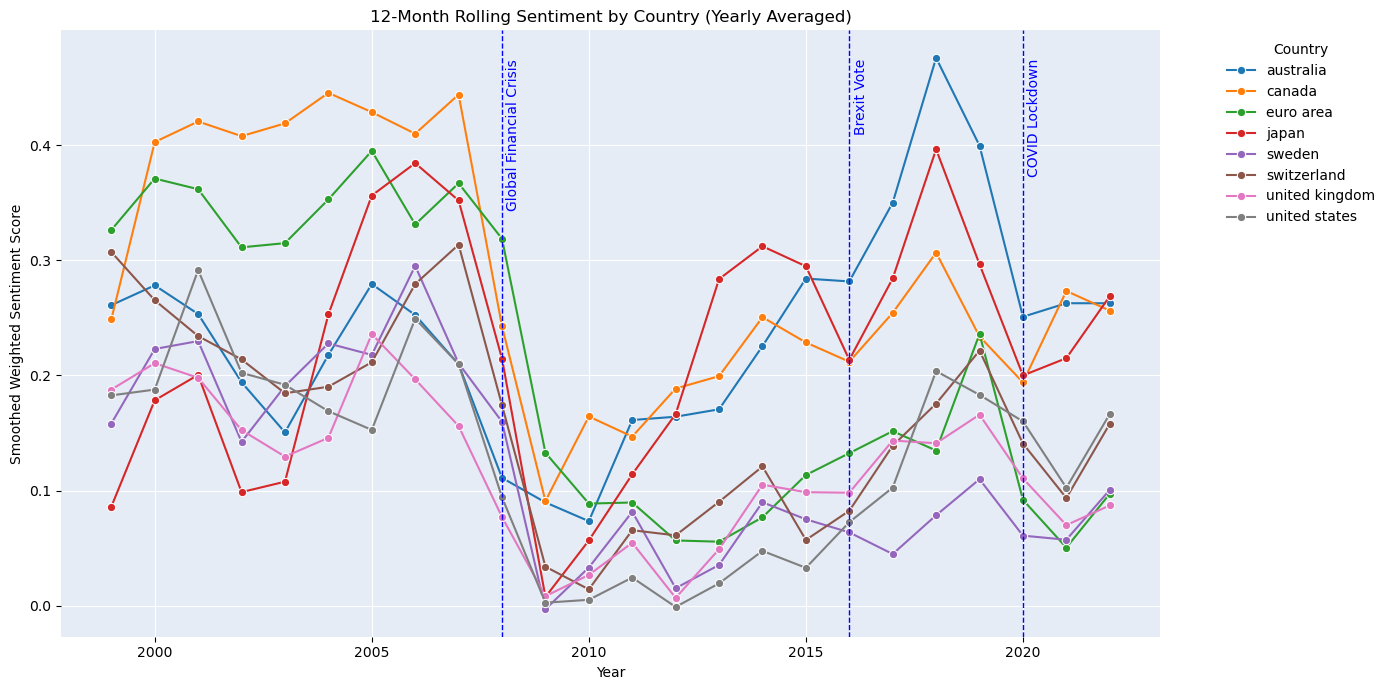

In [89]:
# Event list
events = [
    ("Global Financial Crisis", "2008-09"),
    ("Brexit Vote", "2016-06"),
    ("COVID Lockdown", "2020-03")
]
event_annotations = [(label, pd.to_datetime(date).year) for label, date in events]

# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=yearly_smoothed,
    x='year',
    y='sentiment_12m_rolling',
    hue='country',
    marker='o'
)

# Style plot
ax = plt.gca()
ax.set_facecolor('#E5ECF6')
for spine in ax.spines.values():
    spine.set_visible(False)
plt.grid(color='white')
plt.gcf().set_facecolor('white')

# Add event lines
for label, year in event_annotations:
    plt.axvline(x=year, color='blue', linestyle='--', linewidth=1)
    plt.text(
        x=year + 0.1,
        y=plt.ylim()[1] * 0.95,
        s=label,
        rotation=90,
        verticalalignment='top',
        fontsize=10,
        color='blue'
    )

# Final polish
plt.title('12-Month Rolling Sentiment by Country (Yearly Averaged)')
plt.xlabel('Year')
plt.ylabel('Smoothed Weighted Sentiment Score')
plt.xticks(rotation=0)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left', facecolor='white', frameon=False)
plt.tight_layout()
plt.savefig('12_month_rolling_sentiment_yearly_avg.png', dpi=300, bbox_inches='tight')
plt.show()# Event list

In [90]:
# Filter the DataFrame
filtered_smoothed = yearly_smoothed[yearly_smoothed['country'].isin(selected_countries)]

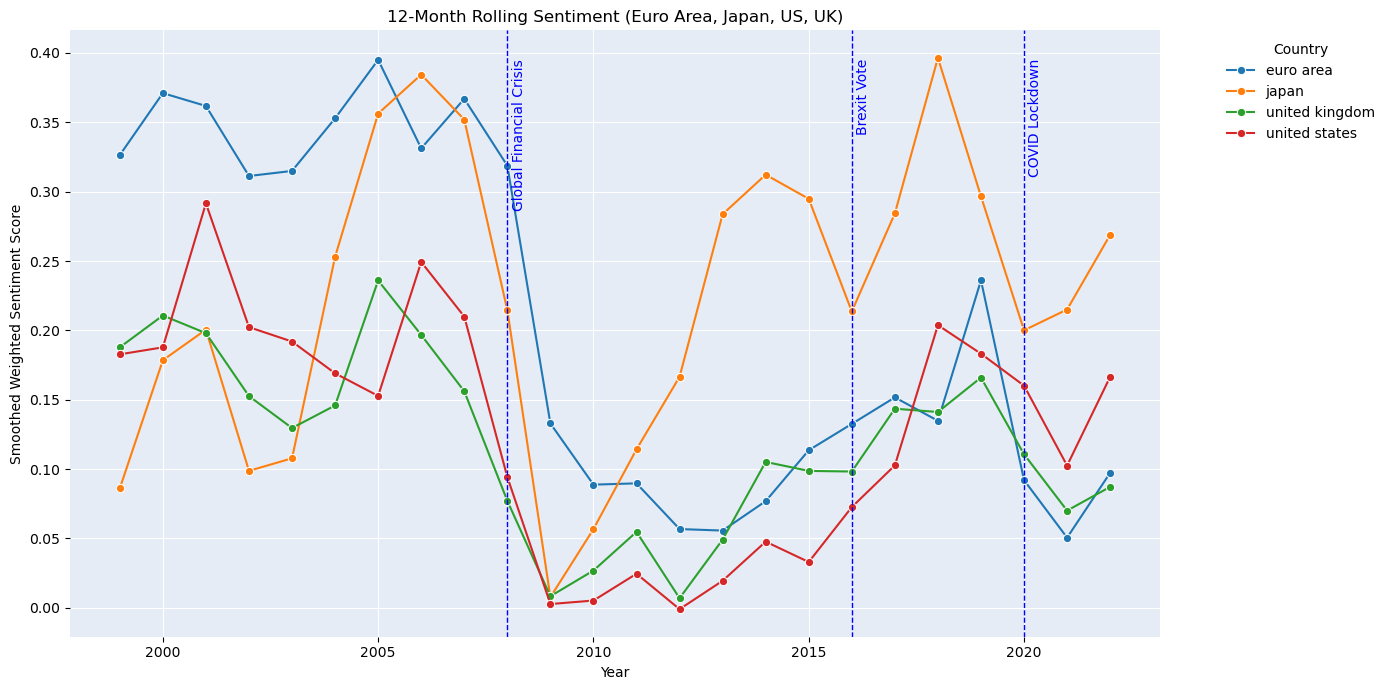

In [91]:
event_annotations = [(label, pd.to_datetime(date).year) for label, date in events]

# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=filtered_smoothed,
    x='year',
    y='sentiment_12m_rolling',
    hue='country',
    marker='o'
)

# Style aesthetics
ax = plt.gca()
ax.set_facecolor('#E5ECF6')
for spine in ax.spines.values():
    spine.set_visible(False)
plt.grid(color='white')
plt.gcf().set_facecolor('white')

# Annotate with events
for label, year in event_annotations:
    plt.axvline(x=year, color='blue', linestyle='--', linewidth=1)
    plt.text(
        x=year + 0.1,
        y=plt.ylim()[1] * 0.95,
        s=label,
        rotation=90,
        verticalalignment='top',
        fontsize=10,
        color='blue'
    )

# Final touches
plt.title('12-Month Rolling Sentiment (Euro Area, Japan, US, UK)')
plt.xlabel('Year')
plt.ylabel('Smoothed Weighted Sentiment Score')
plt.xticks(rotation=0)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left', facecolor='white', frameon=False)
plt.tight_layout()
plt.savefig('12m_rolling_sentiment_g4.png', dpi=300, bbox_inches='tight')
plt.show()